In [34]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
# import tensorflow_addons as tfa
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
%matplotlib inline

seed = 69
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [35]:
## Load data
data = np.load("/kaggle/input/cleaned-data-set/cleaned_mars_for_students.npz")
X_train = data['images']
y_train = data['labels']

X_test = data['test_set']
NUM_CLASSES = len(np.unique(y_train))

In [36]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

class CombinedSegmentationLoss(tf.keras.losses.Loss):
    def __init__(self, 
                 num_classes,
                 class_frequencies=None,
                 alpha=0.25, 
                 gamma=2.0, 
                 focal_weight=1.0, 
                 dice_weight=1.0, 
                 ce_weight=1.0,
                 boundary_weight=1.0,
                 ignore_class=0):
        """
        Combined loss function for semantic segmentation with class balancing.
        
        Args:
            num_classes: Total number of classes including background
            class_frequencies: Array of class frequencies (if None, will be computed during training)
            alpha: Focal loss focusing parameter
            gamma: Focal loss modulating factor
            focal_weight: Weight for focal loss
            dice_weight: Weight for dice loss
            ce_weight: Weight for categorical crossentropy
            boundary_weight: Weight for boundary loss
            ignore_class: Class index to ignore in loss calculation (usually background)
        """
        super().__init__()
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.boundary_weight = boundary_weight
        self.ignore_class = ignore_class
        
        # Initialize class weights if frequencies are provided
        if class_frequencies is not None:
            self.class_weights = self._compute_class_weights(class_frequencies)
        else:
            self.class_weights = None

    def _compute_class_weights(self, class_frequencies):
        """Compute inverse frequency weights for class balancing."""
        eps = 1e-7  # Small epsilon to avoid division by zero
        frequencies = np.array(class_frequencies)
        frequencies[frequencies == 0] = eps
        
        # Inverse frequency weighting
        weights = 1 / (frequencies + eps)
        
        # Normalize weights
        weights = weights / np.sum(weights)

        print("Weigths: ")
        print(tf.constant(weights, dtype=tf.float32))
        
        # Convert to tensor
        return tf.constant(weights, dtype=tf.float32)

    def update_class_weights(self, y_true):
        """Update class weights based on batch statistics."""
        if self.class_weights is None:
            # Calculate class frequencies from current batch
            batch_frequencies = tf.reduce_sum(
                tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes),
                axis=[0, 1, 2]
            )
            self.class_weights = self._compute_class_weights(batch_frequencies)

    def dice_loss(self, y_true, y_pred):
        """Calculate class-weighted Dice loss."""
        # Create mask for non-ignored classes
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        
        # Convert sparse to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        # Calculate Dice coefficient with class weights
        intersection = tf.reduce_sum(y_true_one_hot * weighted_pred * mask[..., tf.newaxis], axis=[0, 1, 2])
        union = tf.reduce_sum(y_true_one_hot * mask[..., tf.newaxis], axis=[0, 1, 2]) + \
                tf.reduce_sum(weighted_pred * mask[..., tf.newaxis], axis=[0, 1, 2])
        
        dice = (2.0 * intersection + K.epsilon()) / (union + K.epsilon())
        return 1.0 - tf.reduce_mean(dice)

    def focal_loss(self, y_true, y_pred):
        """Calculate class-weighted Focal loss."""
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights to predictions
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        # Calculate focal loss with class weights
        ce = -y_true_one_hot * tf.math.log(weighted_pred + K.epsilon())
        weight = tf.pow(1.0 - weighted_pred, self.gamma)
        fl = self.alpha * weight * ce
        
        fl = fl * mask[..., tf.newaxis]
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))

    def boundary_loss(self, y_true, y_pred):
        """Calculate boundary-aware loss using image gradients."""
        # Convert sparse to one-hot
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Calculate gradients
        dy_true, dx_true = tf.image.image_gradients(tf.cast(y_true_one_hot, tf.float32))
        dy_pred, dx_pred = tf.image.image_gradients(y_pred)
        
        # Calculate boundary loss
        boundary_loss = tf.reduce_mean(
            tf.abs(dy_pred - dy_true) + tf.abs(dx_pred - dx_true),
            axis=[1, 2, 3]
        )
        
        return tf.reduce_mean(boundary_loss)

    def categorical_crossentropy(self, y_true, y_pred):
        """Calculate class-weighted categorical crossentropy."""
        mask = tf.cast(y_true != self.ignore_class, tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)
        
        # Apply class weights to predictions
        weighted_pred = y_pred * self.class_weights[tf.newaxis, tf.newaxis, tf.newaxis, :]
        
        ce = -y_true_one_hot * tf.math.log(weighted_pred + K.epsilon())
        ce = ce * mask[..., tf.newaxis]
        return tf.reduce_mean(tf.reduce_sum(ce, axis=-1))

    def call(self, y_true, y_pred):
        """Combine all losses with their respective weights."""
        # Update class weights if necessary
        self.update_class_weights(y_true)
        
        # Calculate individual losses
        fl = self.focal_loss(y_true, y_pred) * self.focal_weight
        dl = self.dice_loss(y_true, y_pred) * self.dice_weight
        ce = self.categorical_crossentropy(y_true, y_pred) * self.ce_weight
        bl = self.boundary_loss(y_true, y_pred) * self.boundary_weight
        
        return fl + dl + ce + bl

In [37]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

def squeeze_excitation_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    # Squeeze
    x = tfkl.GlobalAveragePooling2D()(input_tensor)
    # Excitation
    x = tfkl.Dense(channels // reduction_ratio, activation='relu')(x)
    x = tfkl.Dense(channels, activation='sigmoid')(x)
    # Reshape and multiply
    x = tfkl.Reshape((1, 1, channels))(x)
    return tfkl.multiply([input_tensor, x])

def global_context_module(input_tensor):
    channels = input_tensor.shape[-1]
    # Global context
    context = tfkl.GlobalAveragePooling2D()(input_tensor)
    context = tfkl.Dense(channels // 2, activation='relu')(context)
    context = tfkl.Dense(channels, activation='sigmoid')(context)
    context = tfkl.Reshape((1, 1, channels))(context)
    # Broadcast and multiply
    return tfkl.multiply([input_tensor, context])

def parallel_dilated_conv_block(input_tensor, filters):
    # Three parallel branches with different dilation rates
    d1 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=1)(input_tensor)
    d2 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=2)(input_tensor)
    d4 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=4)(input_tensor)
    d8 = tfkl.Conv2D(filters//4, kernel_size=3, padding='same', dilation_rate=8)(input_tensor)
    
    # Concatenate all branches
    return tfkl.Concatenate()([d1, d2, d4, d8])

def enhanced_unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    return x

def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    # Learning rate schedule
    initial_learning_rate = 0.001  # assuming this is LEARNING_RATE
    decay_steps = 1000
    decay_rate = 0.9
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps, decay_rate
    )
    
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    # Downsampling path
    down_block_1 = enhanced_unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)
    d1 = tfkl.Dropout(0.3)(d1)
    
    down_block_2 = enhanced_unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    d2 = tfkl.Dropout(0.3)(d2)
    
    down_block_3 = enhanced_unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)
    d3 = tfkl.Dropout(0.3)(d3)
    
    down_block_4 = enhanced_unet_block(d3, 256, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)
    d4 = tfkl.Dropout(0.4)(d4)
    
    # Enhanced Bottleneck with all three features
    # 1. Parallel Dilated Convolutions
    bottleneck = parallel_dilated_conv_block(d4, 512)
    bottleneck = tfkl.BatchNormalization()(bottleneck)
    bottleneck = tfkl.Activation('relu')(bottleneck)
    
    # 2. Standard Convolutions
    bottleneck = enhanced_unet_block(bottleneck, 512, name='bottleneck_')
    
    # 3. Global Context Module
    bottleneck = global_context_module(bottleneck)
    
    # 4. Squeeze and Excitation
    bottleneck = squeeze_excitation_block(bottleneck)
    
    bottleneck = tfkl.Dropout(0.5)(bottleneck)
    
    # Upsampling path (keeping same filter counts as original)
    u1 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = enhanced_unet_block(u1, 256, name='up_block1_')
    
    u2 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = enhanced_unet_block(u2, 128, name='up_block2_')
    
    u3 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = enhanced_unet_block(u3, 64, name='up_block3_')
    
    u4 = tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = enhanced_unet_block(u4, 32, name='up_block4_')
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='EnhancedUNet')
    return model



In [38]:
def compute_class_frequencies(y_train):
    """
    Compute pixel-wise class frequencies for semantic segmentation data.
    Safely handles both integer and float labels.
    
    Args:
        y_train: Training masks of shape (N, H, W) or (N, H, W, 1)
                Can contain either integer or float labels
    
    Returns:
        class_frequencies: Array of normalized class frequencies
    """
    # Handle 4D masks (N, H, W, 1)
    if len(y_train.shape) == 4 and y_train.shape[-1] == 1:
        y_train = np.squeeze(y_train, axis=-1)
    
    # Convert to integer labels safely
    y_train_int = np.round(y_train).astype(np.int64)
    
    # Get total number of pixels
    total_pixels = y_train_int.size
    
    # Count occurrences of each class
    class_counts = np.bincount(y_train_int.flatten())
    
    # Convert counts to frequencies
    class_frequencies = class_counts / total_pixels
    
    # Print statistics
    print(f"\nClass Distribution Statistics:")
    print(f"Total pixels analyzed: {total_pixels}")
    print(f"Number of unique classes found: {len(class_counts)}")
    print("\nPer-class breakdown:")
    for class_idx, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
        percentage = freq * 100
        print(f"Class {class_idx:2d}: {count:8d} pixels ({percentage:6.2f}%)")
    
    return class_frequencies

In [39]:
frequencies = compute_class_frequencies(y_train)
print(frequencies)


Class Distribution Statistics:
Total pixels analyzed: 20520960
Number of unique classes found: 5

Per-class breakdown:
Class  0:  4988826 pixels ( 24.31%)
Class  1:  6957538 pixels ( 33.90%)
Class  2:  4776810 pixels ( 23.28%)
Class  3:  3770823 pixels ( 18.38%)
Class  4:    26963 pixels (  0.13%)
[0.2431088  0.33904544 0.23277712 0.18375471 0.00131392]


In [40]:
BATCH_SIZE = 256

LEARNING_RATE = .0001

PATIENCE = 30

EPOCHS = 1000

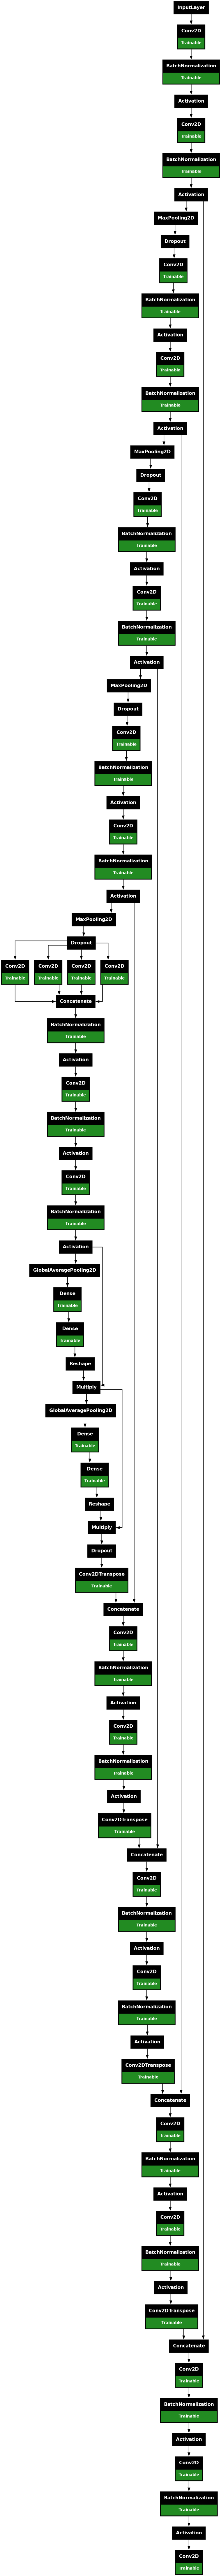

In [41]:
model = get_unet_model()


# Print a detailed summary of the model with expanded nested layers and trainable parameters.
# model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [42]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """

    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)  # Ensure 3 channels
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def random_rotate_images_and_labels(images, labels):
    """
    Function to perform random arbitrary rotation on images and their corresponding labels.
    
    Parameters:
    images (numpy array): Array of grayscale images.
    labels (numpy array): Array of labels corresponding to the images.
    
    Returns:
    rotated_images (numpy array): Array of rotated images.
    rotated_labels (numpy array): Array of rotated labels.
    """
    
    # Create an ImageDataGenerator for random rotation
    datagen = ImageDataGenerator(rotation_range=90)
    
    # Apply the random rotation to each image and its corresponding label
    rotated_images = []
    rotated_labels = []
    
    for img, lbl in zip(images, labels):
        # Expand dimensions to match the expected input shape for ImageDataGenerator
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        lbl = np.expand_dims(lbl, axis=-1)  # Add channel dimension
        
        # Perform random rotation
        img_rotated = datagen.flow(img[np.newaxis, ...], batch_size=1)[0]
        lbl_rotated = datagen.flow(lbl[np.newaxis, ...], batch_size=1)[0]
        
        # Squeeze the dimensions back to original shape
        rotated_images.append(np.squeeze(img_rotated))
        rotated_labels.append(np.squeeze(lbl_rotated))
    
    return np.array(rotated_images), np.array(rotated_labels)

In [44]:
@tf.function
def random_flip_and_solarize(image, label, 
                             flip_lr_seed=None, flip_ud_seed=None, 
                             solarize_seed=None, brightness_seed=None,
                             saturation_seed=None, 
                             threshold=128.0, solarize_prob=0.2, 
                             saturation_factor=(0.5, 1.5),
                             brightness_delta=0.1):
    """Applies random flips (horizontal and vertical), solarization, saturation, and brightness adjustment."""
    
    if flip_lr_seed is None:
        flip_lr_seed = np.random.randint(0, 1000000)
    if flip_ud_seed is None:
        flip_ud_seed = np.random.randint(0, 1000000)
    if solarize_seed is None:
        solarize_seed = np.random.randint(0, 1000000)
    if brightness_seed is None:
        brightness_seed = np.random.randint(0, 1000000)
    if saturation_seed is None:
        saturation_seed = np.random.randint(0, 1000000)
    
    image = tf.expand_dims(tf.expand_dims(image, 0), -1)
    label = tf.expand_dims(tf.expand_dims(label, 0), -1)
    
    # Left-right flip
    flip_lr_prob = tf.random.uniform([], seed=flip_lr_seed)
    image = tf.cond(flip_lr_prob > 0.5,
                    lambda: tf.image.flip_left_right(image),
                    lambda: image)
    label = tf.cond(flip_lr_prob > 0.5,
                    lambda: tf.image.flip_left_right(label),
                    lambda: label)
    
    # Up-down flip
    flip_ud_prob = tf.random.uniform([], seed=flip_ud_seed)
    image = tf.cond(flip_ud_prob > 0.5,
                    lambda: tf.image.flip_up_down(image),
                    lambda: image)
    label = tf.cond(flip_ud_prob > 0.5,
                    lambda: tf.image.flip_up_down(label),
                    lambda: label)
    
    # Solarization
    def solarize(img):
        return tf.where(img > threshold, 255.0 - img, img)
    
    solarize_rand = tf.random.uniform([], seed=solarize_seed)
    image = tf.cond(solarize_rand < solarize_prob,
                    lambda: solarize(image),
                    lambda: image)
    
    # # Random Brightness --> not so useful
    # brightness_rand = tf.random.uniform([], minval=-brightness_delta, 
    #                                      maxval=brightness_delta, 
    #                                      seed=brightness_seed)
    # image = tf.image.adjust_brightness(image, brightness_rand)
    
    image = tf.squeeze(image)
    label = tf.squeeze(label)
    
    return image, label


In [45]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, solarize_seed=None):

    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths

    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    # dataset = dataset.map(
    #     load_single_image,
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, int(y)),
        num_parallel_calls=tf.data.AUTOTUNE

    )

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip_and_solarize(x, y, solarize_seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [46]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=300, random_state=seed
)

In [47]:
# Create the datasets

print("Creating datasets...")

train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    solarize_seed=seed
)

X2_train, y2_train = random_rotate_images_and_labels(X_train, y_train)

train_dataset = make_dataset(
    np.concatenate((X2_train, X_train), axis=0),
    np.concatenate((y2_train, y_train), axis=0),
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    solarize_seed=seed+1
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# test_dataset = make_dataset(
#     test_img, test_lbl,
#     batch_size=BATCH_SIZE,
#     shuffle=False
# )

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (256, 64, 128)
Labels shape: (256, 64, 128)
Labels dtype: <dtype: 'int32'>


In [48]:
def create_segmentation_colormap(num_classes):

    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]
    return colored

In [49]:
# Define custom Mean Intersection Over Union metric

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)



# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image_path, self.label_path
            label = label
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [50]:
LEARNING_RATE = .001

# Compile the model
print("Compiling model...")

# Compute frequencies from your training data
class_frequencies = compute_class_frequencies(y_train)

# Initialize loss with computed frequencies
combined_loss = CombinedSegmentationLoss(
    num_classes=NUM_CLASSES,
    class_frequencies=class_frequencies,
    alpha=0.25,
    gamma=2.0,
    focal_weight=.4,
    dice_weight=0,
    ce_weight=.6,
    boundary_weight=0,
    ignore_class=0
)

model.compile(
    loss=combined_loss,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

print("Model compiled!")

Compiling model...

Class Distribution Statistics:
Total pixels analyzed: 18063360
Number of unique classes found: 5

Per-class breakdown:
Class  0:  4329340 pixels ( 23.97%)
Class  1:  6148209 pixels ( 34.04%)
Class  2:  4263877 pixels ( 23.61%)
Class  3:  3302623 pixels ( 18.28%)
Class  4:    19311 pixels (  0.11%)
Weigths: 
tf.Tensor([0.00438212 0.00308573 0.0044494  0.00574443 0.9823383 ], shape=(5,), dtype=float32)
Model compiled!


In [51]:
# Setup callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(X_train[97], y_train[97])

Epoch 1/1000


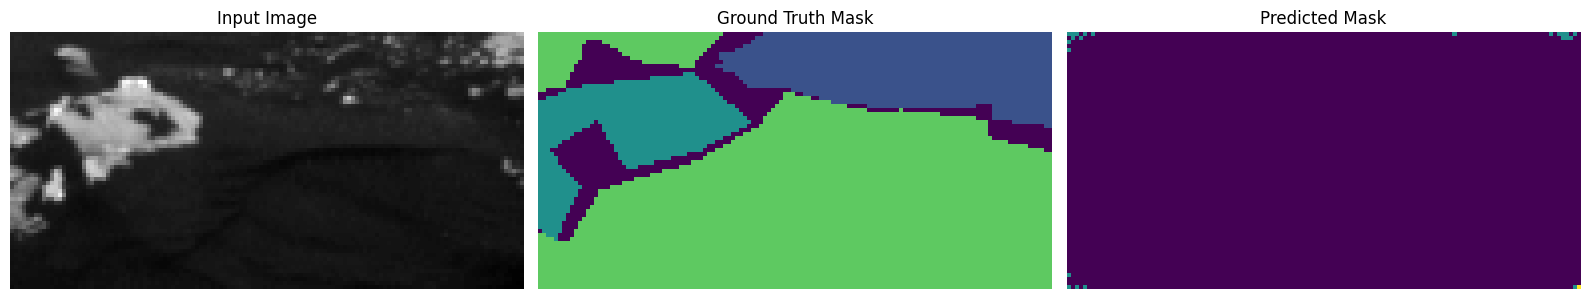

9/9 - 55s - 6s/step - accuracy: 0.2891 - loss: 3.8075 - mean_iou: 0.1360 - val_accuracy: 0.2387 - val_loss: 8.4158 - val_mean_iou: 8.6464e-04
Epoch 2/1000
9/9 - 3s - 385ms/step - accuracy: 0.3945 - loss: 3.5928 - mean_iou: 0.2123 - val_accuracy: 0.2394 - val_loss: 8.5566 - val_mean_iou: 1.5027e-04
Epoch 3/1000
9/9 - 3s - 376ms/step - accuracy: 0.4721 - loss: 3.4909 - mean_iou: 0.2749 - val_accuracy: 0.2385 - val_loss: 8.5489 - val_mean_iou: 7.8373e-04
Epoch 4/1000
9/9 - 3s - 376ms/step - accuracy: 0.5197 - loss: 3.4249 - mean_iou: 0.3126 - val_accuracy: 0.2370 - val_loss: 8.5052 - val_mean_iou: 0.0038
Epoch 5/1000
9/9 - 3s - 377ms/step - accuracy: 0.5207 - loss: 3.3952 - mean_iou: 0.3162 - val_accuracy: 0.2374 - val_loss: 8.4491 - val_mean_iou: 0.0044
Epoch 6/1000


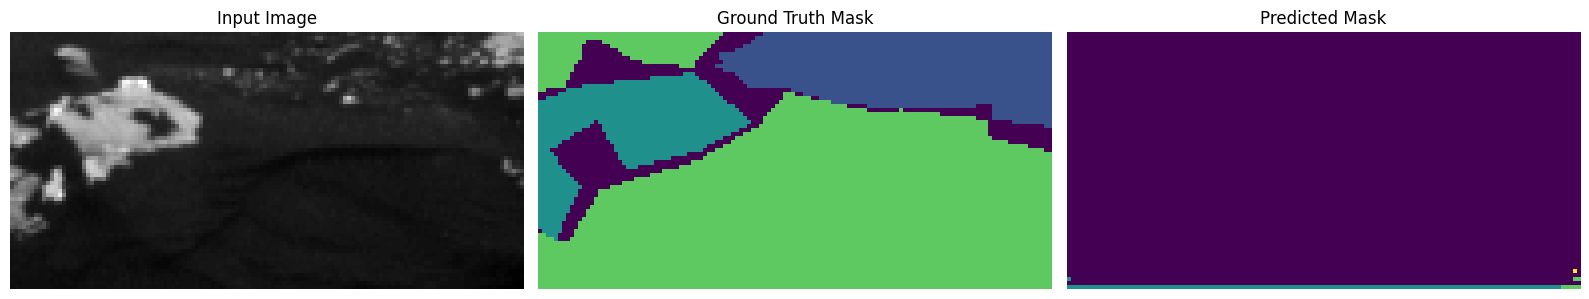

9/9 - 4s - 416ms/step - accuracy: 0.5600 - loss: 3.3445 - mean_iou: 0.3463 - val_accuracy: 0.2376 - val_loss: 8.1460 - val_mean_iou: 0.0109
Epoch 7/1000
9/9 - 3s - 383ms/step - accuracy: 0.5865 - loss: 3.2965 - mean_iou: 0.3747 - val_accuracy: 0.2471 - val_loss: 7.7770 - val_mean_iou: 0.0221
Epoch 8/1000
9/9 - 3s - 382ms/step - accuracy: 0.5936 - loss: 3.2793 - mean_iou: 0.3807 - val_accuracy: 0.2728 - val_loss: 6.9180 - val_mean_iou: 0.0631
Epoch 9/1000
9/9 - 3s - 377ms/step - accuracy: 0.6083 - loss: 3.2612 - mean_iou: 0.3974 - val_accuracy: 0.2366 - val_loss: 8.5072 - val_mean_iou: 0.0035
Epoch 10/1000
9/9 - 3s - 376ms/step - accuracy: 0.5910 - loss: 3.2684 - mean_iou: 0.3830 - val_accuracy: 0.2382 - val_loss: 8.3955 - val_mean_iou: 0.0092
Epoch 11/1000


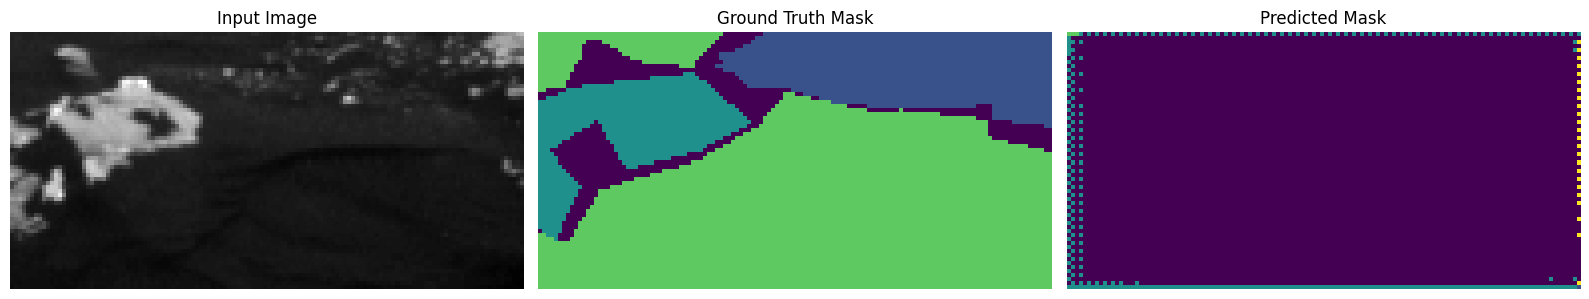

9/9 - 4s - 417ms/step - accuracy: 0.6002 - loss: 3.2549 - mean_iou: 0.3899 - val_accuracy: 0.2390 - val_loss: 8.1696 - val_mean_iou: 0.0148
Epoch 12/1000
9/9 - 3s - 376ms/step - accuracy: 0.6088 - loss: 3.2346 - mean_iou: 0.3994 - val_accuracy: 0.2437 - val_loss: 6.8451 - val_mean_iou: 0.0642
Epoch 13/1000
9/9 - 3s - 377ms/step - accuracy: 0.6050 - loss: 3.2357 - mean_iou: 0.3942 - val_accuracy: 0.2363 - val_loss: 7.5446 - val_mean_iou: 0.0360
Epoch 14/1000
9/9 - 3s - 381ms/step - accuracy: 0.6150 - loss: 3.2159 - mean_iou: 0.4071 - val_accuracy: 0.3765 - val_loss: 5.5722 - val_mean_iou: 0.1401
Epoch 15/1000
9/9 - 3s - 382ms/step - accuracy: 0.6237 - loss: 3.1991 - mean_iou: 0.4162 - val_accuracy: 0.4153 - val_loss: 4.9532 - val_mean_iou: 0.1877
Epoch 16/1000


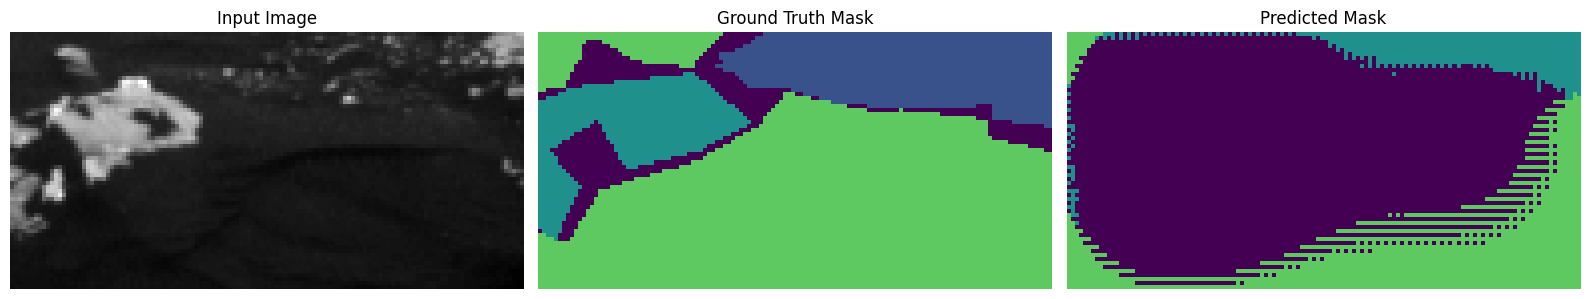

9/9 - 4s - 418ms/step - accuracy: 0.6269 - loss: 3.1913 - mean_iou: 0.4189 - val_accuracy: 0.3737 - val_loss: 5.4482 - val_mean_iou: 0.1405
Epoch 17/1000
9/9 - 3s - 381ms/step - accuracy: 0.6279 - loss: 3.1938 - mean_iou: 0.4190 - val_accuracy: 0.4577 - val_loss: 4.3804 - val_mean_iou: 0.2346
Epoch 18/1000
9/9 - 3s - 377ms/step - accuracy: 0.6181 - loss: 3.2047 - mean_iou: 0.4072 - val_accuracy: 0.3649 - val_loss: 4.5395 - val_mean_iou: 0.1629
Epoch 19/1000
9/9 - 3s - 376ms/step - accuracy: 0.6392 - loss: 3.1717 - mean_iou: 0.4327 - val_accuracy: 0.4439 - val_loss: 5.0534 - val_mean_iou: 0.1933
Epoch 20/1000
9/9 - 3s - 382ms/step - accuracy: 0.6356 - loss: 3.1743 - mean_iou: 0.4280 - val_accuracy: 0.4708 - val_loss: 3.7605 - val_mean_iou: 0.2595
Epoch 21/1000


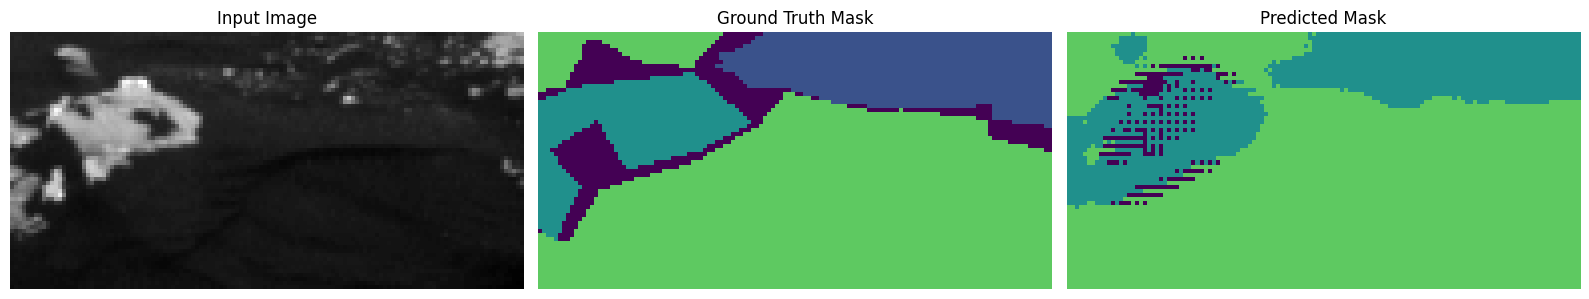

9/9 - 4s - 420ms/step - accuracy: 0.6389 - loss: 3.1645 - mean_iou: 0.4356 - val_accuracy: 0.6186 - val_loss: 3.3510 - val_mean_iou: 0.3976
Epoch 22/1000
9/9 - 3s - 376ms/step - accuracy: 0.6403 - loss: 3.1629 - mean_iou: 0.4347 - val_accuracy: 0.5958 - val_loss: 3.3820 - val_mean_iou: 0.3742
Epoch 23/1000
9/9 - 3s - 376ms/step - accuracy: 0.6308 - loss: 3.1785 - mean_iou: 0.4221 - val_accuracy: 0.5966 - val_loss: 3.3937 - val_mean_iou: 0.3650
Epoch 24/1000
9/9 - 3s - 376ms/step - accuracy: 0.6411 - loss: 3.1613 - mean_iou: 0.4342 - val_accuracy: 0.6028 - val_loss: 3.2897 - val_mean_iou: 0.3893
Epoch 25/1000
9/9 - 3s - 378ms/step - accuracy: 0.6548 - loss: 3.1411 - mean_iou: 0.4514 - val_accuracy: 0.5619 - val_loss: 3.3915 - val_mean_iou: 0.3530
Epoch 26/1000


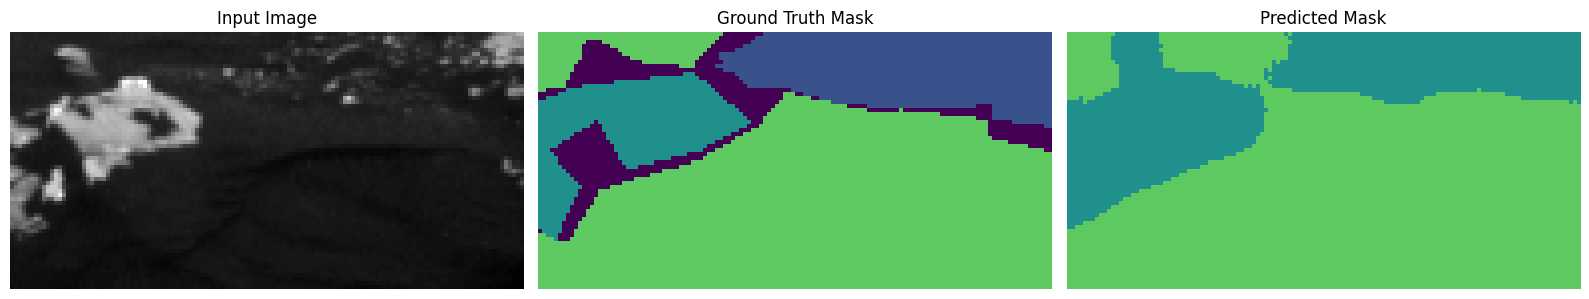

9/9 - 4s - 417ms/step - accuracy: 0.6557 - loss: 3.1418 - mean_iou: 0.4526 - val_accuracy: 0.5497 - val_loss: 3.4723 - val_mean_iou: 0.3382
Epoch 27/1000
9/9 - 3s - 377ms/step - accuracy: 0.6507 - loss: 3.1436 - mean_iou: 0.4452 - val_accuracy: 0.5788 - val_loss: 3.4375 - val_mean_iou: 0.3676
Epoch 28/1000
9/9 - 3s - 376ms/step - accuracy: 0.6533 - loss: 3.1372 - mean_iou: 0.4497 - val_accuracy: 0.5268 - val_loss: 3.5458 - val_mean_iou: 0.3285
Epoch 29/1000
9/9 - 3s - 377ms/step - accuracy: 0.6486 - loss: 3.1435 - mean_iou: 0.4454 - val_accuracy: 0.6071 - val_loss: 3.3048 - val_mean_iou: 0.3987
Epoch 30/1000
9/9 - 3s - 376ms/step - accuracy: 0.6522 - loss: 3.1408 - mean_iou: 0.4476 - val_accuracy: 0.5908 - val_loss: 3.3667 - val_mean_iou: 0.3724
Epoch 31/1000


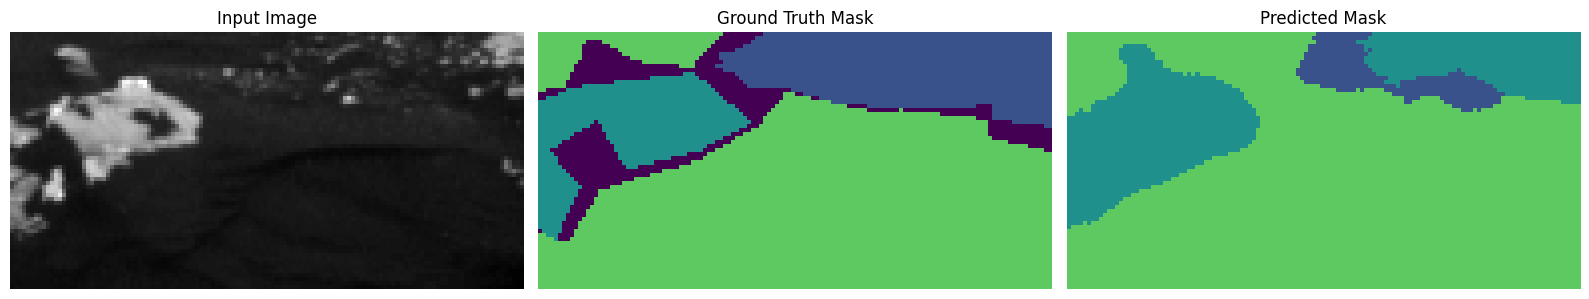

9/9 - 4s - 421ms/step - accuracy: 0.6505 - loss: 3.1387 - mean_iou: 0.4456 - val_accuracy: 0.6353 - val_loss: 3.1853 - val_mean_iou: 0.4261
Epoch 32/1000
9/9 - 3s - 376ms/step - accuracy: 0.6491 - loss: 3.1417 - mean_iou: 0.4437 - val_accuracy: 0.6343 - val_loss: 3.2151 - val_mean_iou: 0.4277
Epoch 33/1000
9/9 - 3s - 376ms/step - accuracy: 0.6596 - loss: 3.1249 - mean_iou: 0.4573 - val_accuracy: 0.6128 - val_loss: 3.3341 - val_mean_iou: 0.4047
Epoch 34/1000
9/9 - 3s - 377ms/step - accuracy: 0.6611 - loss: 3.1188 - mean_iou: 0.4594 - val_accuracy: 0.5715 - val_loss: 3.3420 - val_mean_iou: 0.3508
Epoch 35/1000
9/9 - 3s - 377ms/step - accuracy: 0.6561 - loss: 3.1324 - mean_iou: 0.4525 - val_accuracy: 0.4959 - val_loss: 3.5994 - val_mean_iou: 0.2578
Epoch 36/1000


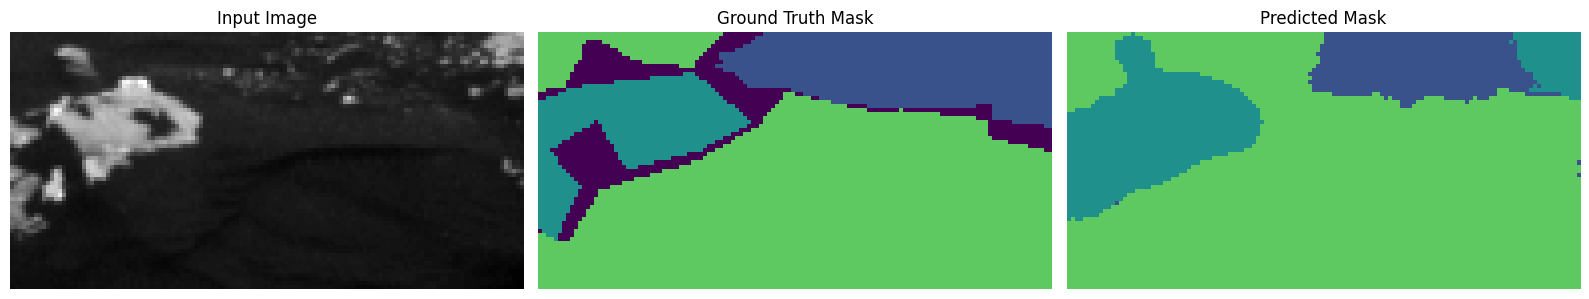

9/9 - 4s - 415ms/step - accuracy: 0.6459 - loss: 3.1386 - mean_iou: 0.4406 - val_accuracy: 0.5318 - val_loss: 3.5647 - val_mean_iou: 0.3146
Epoch 37/1000
9/9 - 3s - 376ms/step - accuracy: 0.6567 - loss: 3.1306 - mean_iou: 0.4548 - val_accuracy: 0.6078 - val_loss: 3.2458 - val_mean_iou: 0.3958
Epoch 38/1000
9/9 - 3s - 376ms/step - accuracy: 0.6507 - loss: 3.1391 - mean_iou: 0.4479 - val_accuracy: 0.5677 - val_loss: 3.4645 - val_mean_iou: 0.3601
Epoch 39/1000
9/9 - 3s - 376ms/step - accuracy: 0.6632 - loss: 3.1190 - mean_iou: 0.4624 - val_accuracy: 0.5850 - val_loss: 3.4364 - val_mean_iou: 0.3767
Epoch 40/1000
9/9 - 3s - 377ms/step - accuracy: 0.6634 - loss: 3.1105 - mean_iou: 0.4614 - val_accuracy: 0.6101 - val_loss: 3.2786 - val_mean_iou: 0.3959
Epoch 41/1000


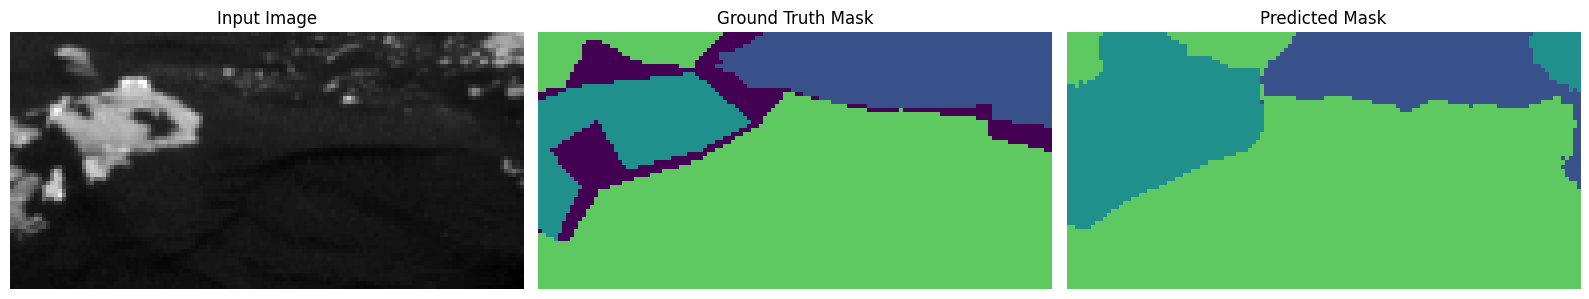

9/9 - 4s - 416ms/step - accuracy: 0.6654 - loss: 3.1141 - mean_iou: 0.4629 - val_accuracy: 0.5550 - val_loss: 3.4326 - val_mean_iou: 0.3259
Epoch 42/1000
9/9 - 3s - 376ms/step - accuracy: 0.6680 - loss: 3.1087 - mean_iou: 0.4670 - val_accuracy: 0.4750 - val_loss: 3.6902 - val_mean_iou: 0.2355
Epoch 43/1000
9/9 - 3s - 377ms/step - accuracy: 0.6642 - loss: 3.1169 - mean_iou: 0.4634 - val_accuracy: 0.5236 - val_loss: 3.4624 - val_mean_iou: 0.2866
Epoch 44/1000
9/9 - 3s - 378ms/step - accuracy: 0.6675 - loss: 3.1108 - mean_iou: 0.4671 - val_accuracy: 0.6062 - val_loss: 3.2417 - val_mean_iou: 0.4023
Epoch 45/1000
9/9 - 3s - 377ms/step - accuracy: 0.6712 - loss: 3.1047 - mean_iou: 0.4717 - val_accuracy: 0.4701 - val_loss: 3.5461 - val_mean_iou: 0.2231
Epoch 46/1000


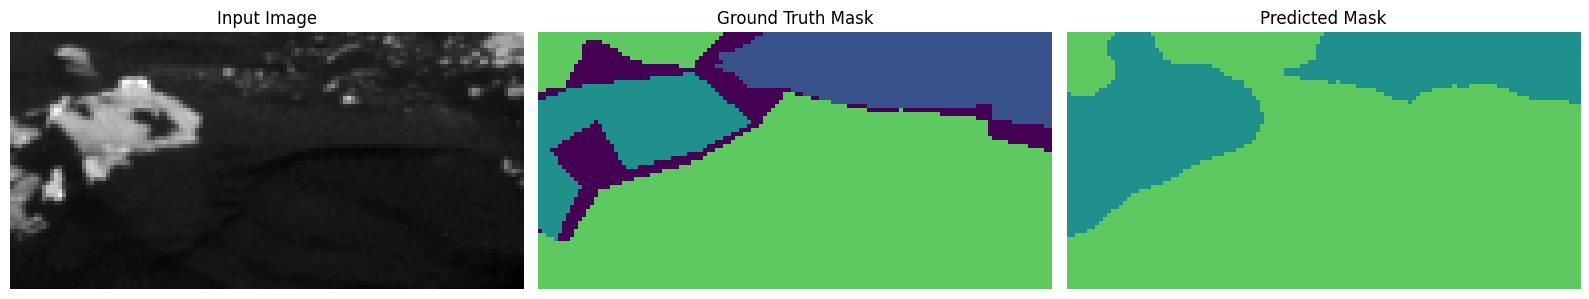

9/9 - 4s - 472ms/step - accuracy: 0.6664 - loss: 3.1076 - mean_iou: 0.4655 - val_accuracy: 0.6233 - val_loss: 3.2335 - val_mean_iou: 0.4193
Epoch 47/1000
9/9 - 3s - 377ms/step - accuracy: 0.6694 - loss: 3.1029 - mean_iou: 0.4684 - val_accuracy: 0.5721 - val_loss: 3.4521 - val_mean_iou: 0.3705
Epoch 48/1000
9/9 - 3s - 378ms/step - accuracy: 0.6658 - loss: 3.1069 - mean_iou: 0.4637 - val_accuracy: 0.5165 - val_loss: 3.4567 - val_mean_iou: 0.2779
Epoch 49/1000
9/9 - 3s - 383ms/step - accuracy: 0.6723 - loss: 3.1008 - mean_iou: 0.4733 - val_accuracy: 0.6357 - val_loss: 3.1818 - val_mean_iou: 0.4285
Epoch 50/1000
9/9 - 3s - 377ms/step - accuracy: 0.6695 - loss: 3.1039 - mean_iou: 0.4694 - val_accuracy: 0.6088 - val_loss: 3.2762 - val_mean_iou: 0.3967
Epoch 51/1000


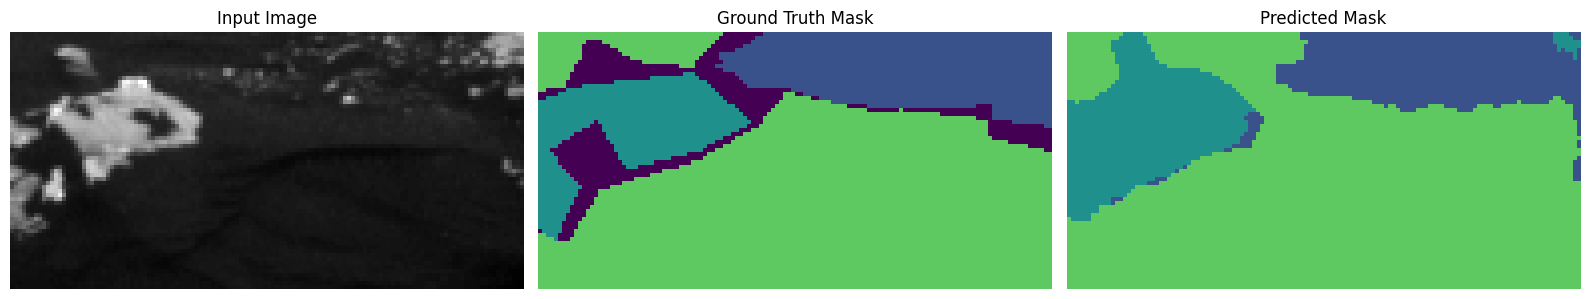

9/9 - 4s - 407ms/step - accuracy: 0.6725 - loss: 3.0918 - mean_iou: 0.4741 - val_accuracy: 0.5574 - val_loss: 3.4353 - val_mean_iou: 0.3283
Epoch 52/1000
9/9 - 3s - 379ms/step - accuracy: 0.6707 - loss: 3.0984 - mean_iou: 0.4713 - val_accuracy: 0.5911 - val_loss: 3.3219 - val_mean_iou: 0.3676
Epoch 53/1000
9/9 - 3s - 378ms/step - accuracy: 0.6743 - loss: 3.0957 - mean_iou: 0.4747 - val_accuracy: 0.5338 - val_loss: 3.4356 - val_mean_iou: 0.3037
Epoch 54/1000
9/9 - 3s - 377ms/step - accuracy: 0.6727 - loss: 3.0957 - mean_iou: 0.4724 - val_accuracy: 0.5582 - val_loss: 3.3763 - val_mean_iou: 0.3287
Epoch 55/1000
9/9 - 3s - 377ms/step - accuracy: 0.6736 - loss: 3.0942 - mean_iou: 0.4750 - val_accuracy: 0.6035 - val_loss: 3.2293 - val_mean_iou: 0.3760
Epoch 56/1000


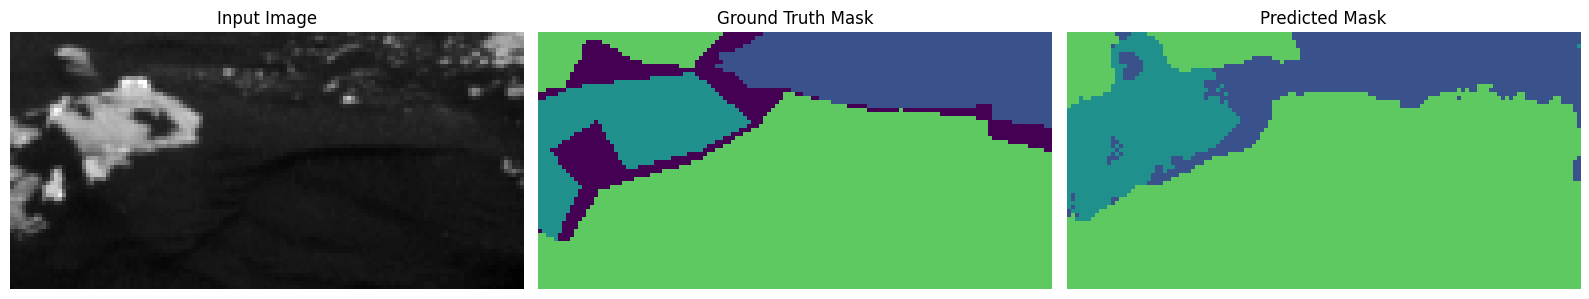

9/9 - 4s - 407ms/step - accuracy: 0.6762 - loss: 3.0891 - mean_iou: 0.4796 - val_accuracy: 0.6112 - val_loss: 3.2057 - val_mean_iou: 0.3891
Epoch 57/1000
9/9 - 3s - 382ms/step - accuracy: 0.6800 - loss: 3.0841 - mean_iou: 0.4818 - val_accuracy: 0.6437 - val_loss: 3.1698 - val_mean_iou: 0.4308
Epoch 58/1000
9/9 - 3s - 376ms/step - accuracy: 0.6748 - loss: 3.0913 - mean_iou: 0.4768 - val_accuracy: 0.5658 - val_loss: 3.3294 - val_mean_iou: 0.3442
Epoch 59/1000
9/9 - 3s - 382ms/step - accuracy: 0.6800 - loss: 3.0887 - mean_iou: 0.4823 - val_accuracy: 0.6684 - val_loss: 3.1166 - val_mean_iou: 0.4675
Epoch 60/1000
9/9 - 3s - 377ms/step - accuracy: 0.6789 - loss: 3.0840 - mean_iou: 0.4801 - val_accuracy: 0.6559 - val_loss: 3.1450 - val_mean_iou: 0.4549
Epoch 61/1000


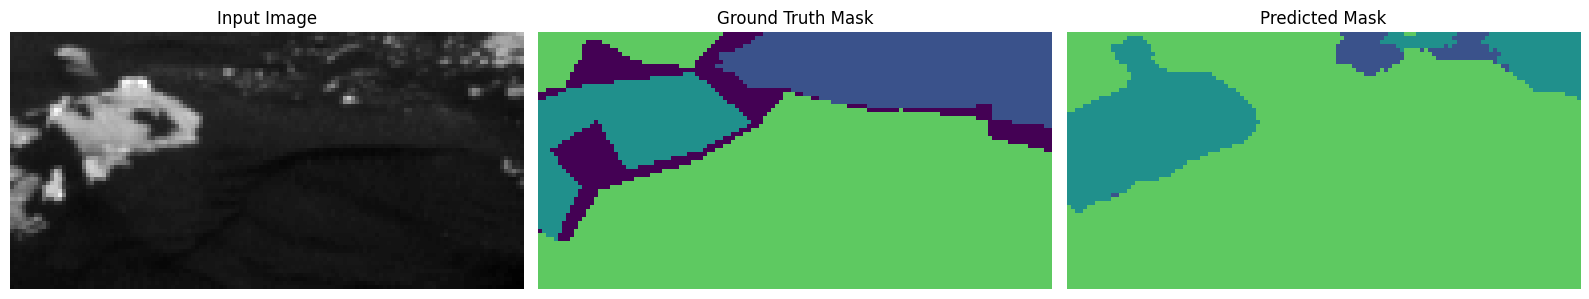

9/9 - 4s - 419ms/step - accuracy: 0.6829 - loss: 3.0802 - mean_iou: 0.4861 - val_accuracy: 0.6303 - val_loss: 3.1835 - val_mean_iou: 0.4297
Epoch 62/1000
9/9 - 3s - 378ms/step - accuracy: 0.6815 - loss: 3.0816 - mean_iou: 0.4846 - val_accuracy: 0.5289 - val_loss: 3.4755 - val_mean_iou: 0.3308
Epoch 63/1000
9/9 - 3s - 376ms/step - accuracy: 0.6783 - loss: 3.0840 - mean_iou: 0.4816 - val_accuracy: 0.6298 - val_loss: 3.2604 - val_mean_iou: 0.4246
Epoch 64/1000
9/9 - 3s - 376ms/step - accuracy: 0.6827 - loss: 3.0773 - mean_iou: 0.4851 - val_accuracy: 0.5877 - val_loss: 3.3640 - val_mean_iou: 0.3883
Epoch 65/1000
9/9 - 3s - 376ms/step - accuracy: 0.6888 - loss: 3.0734 - mean_iou: 0.4948 - val_accuracy: 0.5253 - val_loss: 3.4171 - val_mean_iou: 0.2935
Epoch 66/1000


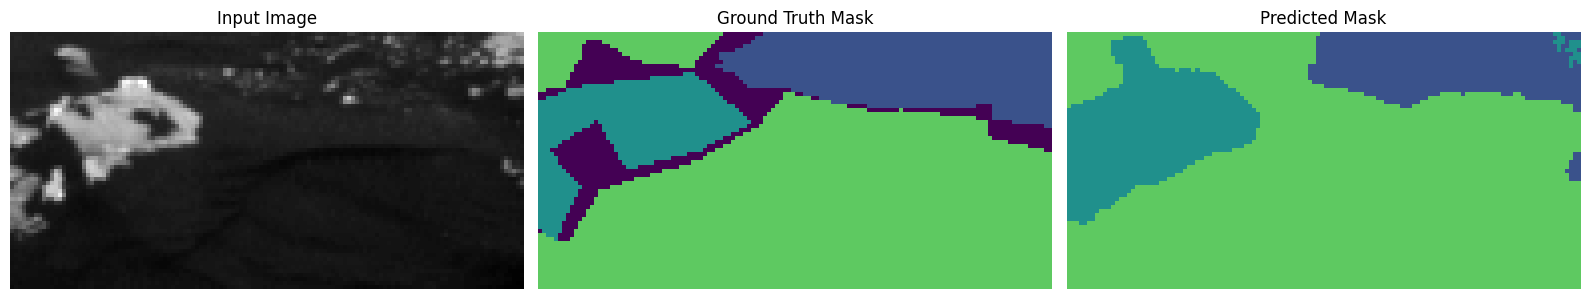

9/9 - 4s - 416ms/step - accuracy: 0.6847 - loss: 3.0745 - mean_iou: 0.4882 - val_accuracy: 0.5184 - val_loss: 3.4467 - val_mean_iou: 0.2929
Epoch 67/1000
9/9 - 3s - 377ms/step - accuracy: 0.6856 - loss: 3.0745 - mean_iou: 0.4893 - val_accuracy: 0.6005 - val_loss: 3.2737 - val_mean_iou: 0.3878
Epoch 68/1000
9/9 - 3s - 376ms/step - accuracy: 0.6915 - loss: 3.0628 - mean_iou: 0.6216 - val_accuracy: 0.4958 - val_loss: 3.5340 - val_mean_iou: 0.2644
Epoch 69/1000
9/9 - 3s - 376ms/step - accuracy: 0.6870 - loss: 3.0685 - mean_iou: 0.4922 - val_accuracy: 0.6072 - val_loss: 3.2945 - val_mean_iou: 0.4834
Epoch 70/1000
9/9 - 3s - 376ms/step - accuracy: 0.6899 - loss: 3.0620 - mean_iou: 0.4962 - val_accuracy: 0.6194 - val_loss: 3.2159 - val_mean_iou: 0.4031
Epoch 71/1000


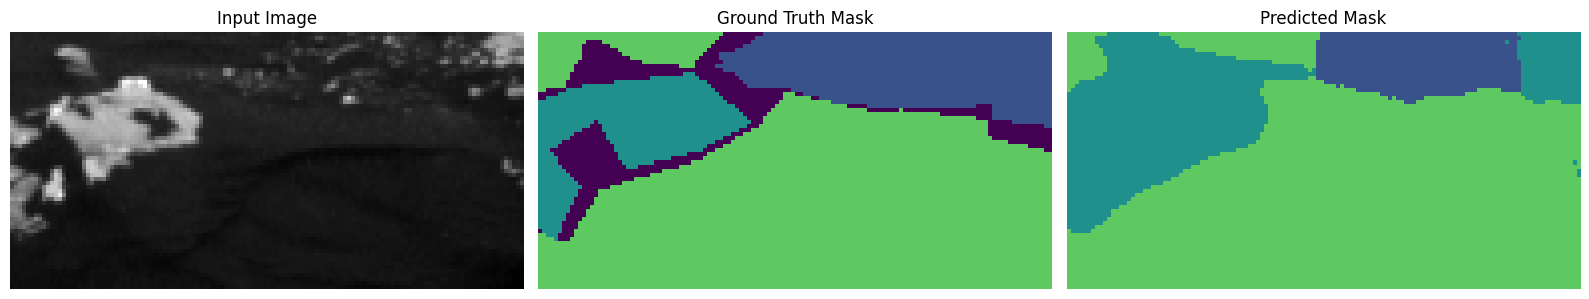

9/9 - 4s - 415ms/step - accuracy: 0.6843 - loss: 3.0773 - mean_iou: 0.4880 - val_accuracy: 0.6609 - val_loss: 3.1345 - val_mean_iou: 0.5729
Epoch 72/1000
9/9 - 3s - 382ms/step - accuracy: 0.6839 - loss: 3.0751 - mean_iou: 0.6085 - val_accuracy: 0.6757 - val_loss: 3.0942 - val_mean_iou: 0.4766
Epoch 73/1000
9/9 - 3s - 377ms/step - accuracy: 0.6841 - loss: 3.0703 - mean_iou: 0.4885 - val_accuracy: 0.6424 - val_loss: 3.2043 - val_mean_iou: 0.5526
Epoch 74/1000
9/9 - 3s - 376ms/step - accuracy: 0.6921 - loss: 3.0614 - mean_iou: 0.6220 - val_accuracy: 0.6230 - val_loss: 3.2185 - val_mean_iou: 0.5142
Epoch 75/1000
9/9 - 3s - 377ms/step - accuracy: 0.6884 - loss: 3.0661 - mean_iou: 0.6174 - val_accuracy: 0.6160 - val_loss: 3.2468 - val_mean_iou: 0.4001
Epoch 76/1000


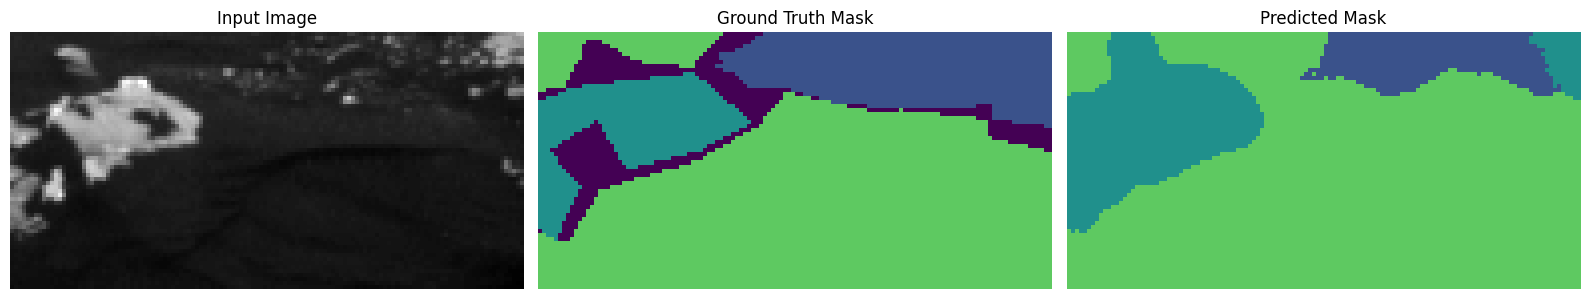

9/9 - 4s - 406ms/step - accuracy: 0.6861 - loss: 3.0730 - mean_iou: 0.4917 - val_accuracy: 0.6177 - val_loss: 3.1953 - val_mean_iou: 0.5063
Epoch 77/1000
9/9 - 3s - 377ms/step - accuracy: 0.6859 - loss: 3.0783 - mean_iou: 0.4891 - val_accuracy: 0.6553 - val_loss: 3.1479 - val_mean_iou: 0.4524
Epoch 78/1000
9/9 - 3s - 377ms/step - accuracy: 0.6867 - loss: 3.0722 - mean_iou: 0.4900 - val_accuracy: 0.5863 - val_loss: 3.2804 - val_mean_iou: 0.3746
Epoch 79/1000
9/9 - 3s - 377ms/step - accuracy: 0.6812 - loss: 3.0736 - mean_iou: 0.4846 - val_accuracy: 0.6449 - val_loss: 3.1669 - val_mean_iou: 0.4396
Epoch 80/1000
9/9 - 3s - 377ms/step - accuracy: 0.6928 - loss: 3.0638 - mean_iou: 0.4999 - val_accuracy: 0.6406 - val_loss: 3.1707 - val_mean_iou: 0.4293
Epoch 81/1000


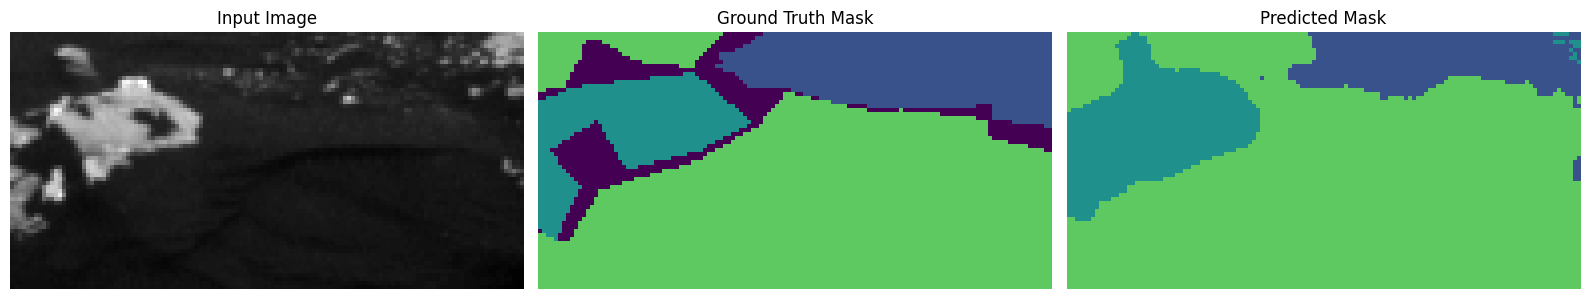

9/9 - 4s - 415ms/step - accuracy: 0.6906 - loss: 3.0636 - mean_iou: 0.4967 - val_accuracy: 0.6125 - val_loss: 3.2092 - val_mean_iou: 0.4011
Epoch 82/1000
9/9 - 3s - 377ms/step - accuracy: 0.6926 - loss: 3.0665 - mean_iou: 0.4989 - val_accuracy: 0.6461 - val_loss: 3.1806 - val_mean_iou: 0.4356
Epoch 83/1000
9/9 - 3s - 376ms/step - accuracy: 0.6952 - loss: 3.0547 - mean_iou: 0.5024 - val_accuracy: 0.6282 - val_loss: 3.2109 - val_mean_iou: 0.4206
Epoch 84/1000
9/9 - 3s - 377ms/step - accuracy: 0.6981 - loss: 3.0477 - mean_iou: 0.5066 - val_accuracy: 0.6656 - val_loss: 3.1098 - val_mean_iou: 0.4658
Epoch 85/1000
9/9 - 3s - 376ms/step - accuracy: 0.6971 - loss: 3.0533 - mean_iou: 0.5055 - val_accuracy: 0.5241 - val_loss: 3.6513 - val_mean_iou: 0.3284
Epoch 86/1000


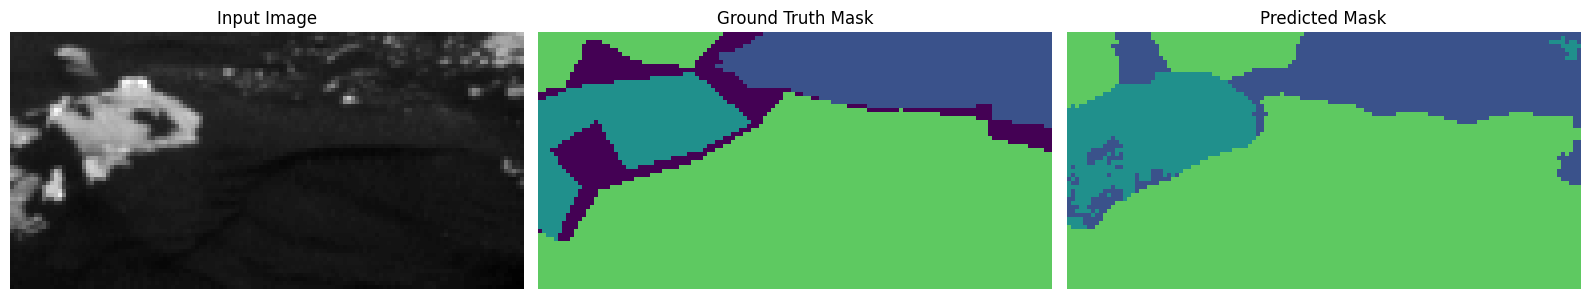

9/9 - 4s - 415ms/step - accuracy: 0.6980 - loss: 3.0494 - mean_iou: 0.5062 - val_accuracy: 0.6493 - val_loss: 3.1482 - val_mean_iou: 0.5452
Epoch 87/1000
9/9 - 3s - 376ms/step - accuracy: 0.6995 - loss: 3.0475 - mean_iou: 0.6358 - val_accuracy: 0.6419 - val_loss: 3.1496 - val_mean_iou: 0.4375
Epoch 88/1000
9/9 - 3s - 376ms/step - accuracy: 0.6831 - loss: 3.0767 - mean_iou: 0.4868 - val_accuracy: 0.6068 - val_loss: 3.2952 - val_mean_iou: 0.3979
Epoch 89/1000
9/9 - 3s - 377ms/step - accuracy: 0.6856 - loss: 3.0710 - mean_iou: 0.4902 - val_accuracy: 0.5989 - val_loss: 3.3594 - val_mean_iou: 0.3921
Epoch 90/1000
9/9 - 3s - 376ms/step - accuracy: 0.6908 - loss: 3.0688 - mean_iou: 0.6202 - val_accuracy: 0.5623 - val_loss: 3.4050 - val_mean_iou: 0.3247
Epoch 91/1000


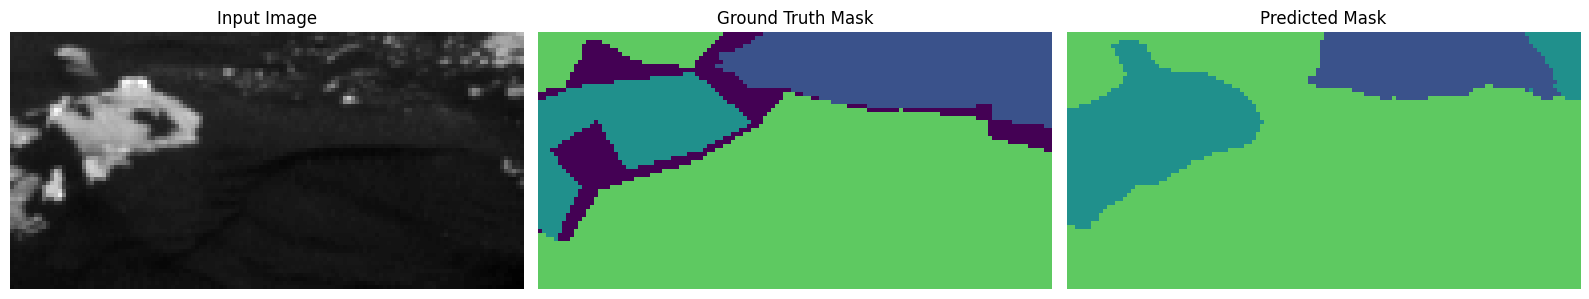

9/9 - 4s - 413ms/step - accuracy: 0.6889 - loss: 3.0675 - mean_iou: 0.4944 - val_accuracy: 0.6813 - val_loss: 3.1008 - val_mean_iou: 0.4850
Epoch 92/1000
9/9 - 3s - 376ms/step - accuracy: 0.6911 - loss: 3.0614 - mean_iou: 0.4986 - val_accuracy: 0.6811 - val_loss: 3.1032 - val_mean_iou: 0.4799
Epoch 93/1000
9/9 - 3s - 377ms/step - accuracy: 0.6956 - loss: 3.0542 - mean_iou: 0.5026 - val_accuracy: 0.6798 - val_loss: 3.0971 - val_mean_iou: 0.4799
Epoch 94/1000
9/9 - 3s - 376ms/step - accuracy: 0.6999 - loss: 3.0483 - mean_iou: 0.5090 - val_accuracy: 0.6560 - val_loss: 3.1605 - val_mean_iou: 0.4410
Epoch 95/1000
9/9 - 3s - 377ms/step - accuracy: 0.6985 - loss: 3.0466 - mean_iou: 0.5079 - val_accuracy: 0.6358 - val_loss: 3.1773 - val_mean_iou: 0.4256
Epoch 96/1000


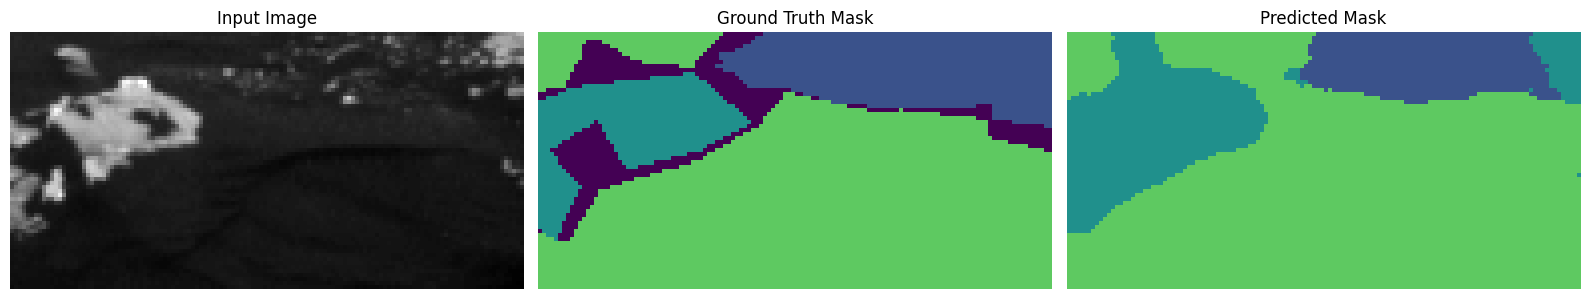

9/9 - 4s - 407ms/step - accuracy: 0.7014 - loss: 3.0460 - mean_iou: 0.6375 - val_accuracy: 0.6682 - val_loss: 3.1299 - val_mean_iou: 0.5783
Epoch 97/1000
9/9 - 3s - 376ms/step - accuracy: 0.7005 - loss: 3.0441 - mean_iou: 0.5100 - val_accuracy: 0.6244 - val_loss: 3.2379 - val_mean_iou: 0.4956
Epoch 98/1000
9/9 - 3s - 377ms/step - accuracy: 0.7047 - loss: 3.0403 - mean_iou: 0.5158 - val_accuracy: 0.5764 - val_loss: 3.3627 - val_mean_iou: 0.4266
Epoch 99/1000
9/9 - 3s - 376ms/step - accuracy: 0.6975 - loss: 3.0506 - mean_iou: 0.5059 - val_accuracy: 0.6345 - val_loss: 3.1641 - val_mean_iou: 0.4193
Epoch 100/1000
9/9 - 3s - 376ms/step - accuracy: 0.6935 - loss: 3.0592 - mean_iou: 0.5001 - val_accuracy: 0.6465 - val_loss: 3.1429 - val_mean_iou: 0.4476
Epoch 101/1000


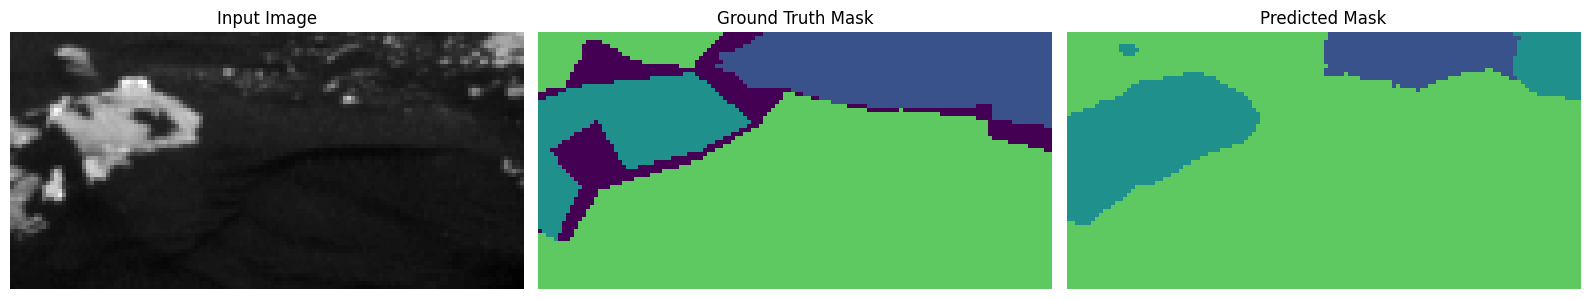

9/9 - 4s - 413ms/step - accuracy: 0.6987 - loss: 3.0486 - mean_iou: 0.5069 - val_accuracy: 0.6975 - val_loss: 3.0534 - val_mean_iou: 0.6300
Epoch 102/1000
9/9 - 3s - 377ms/step - accuracy: 0.7039 - loss: 3.0432 - mean_iou: 0.6427 - val_accuracy: 0.6270 - val_loss: 3.2883 - val_mean_iou: 0.5359
Epoch 103/1000
9/9 - 3s - 377ms/step - accuracy: 0.6943 - loss: 3.0594 - mean_iou: 0.6264 - val_accuracy: 0.4629 - val_loss: 3.7331 - val_mean_iou: 0.3551
Epoch 104/1000
9/9 - 3s - 376ms/step - accuracy: 0.6992 - loss: 3.0477 - mean_iou: 0.6356 - val_accuracy: 0.6316 - val_loss: 3.2237 - val_mean_iou: 0.5093
Epoch 105/1000
9/9 - 3s - 377ms/step - accuracy: 0.6999 - loss: 3.0472 - mean_iou: 0.6345 - val_accuracy: 0.6662 - val_loss: 3.1502 - val_mean_iou: 0.5838
Epoch 106/1000


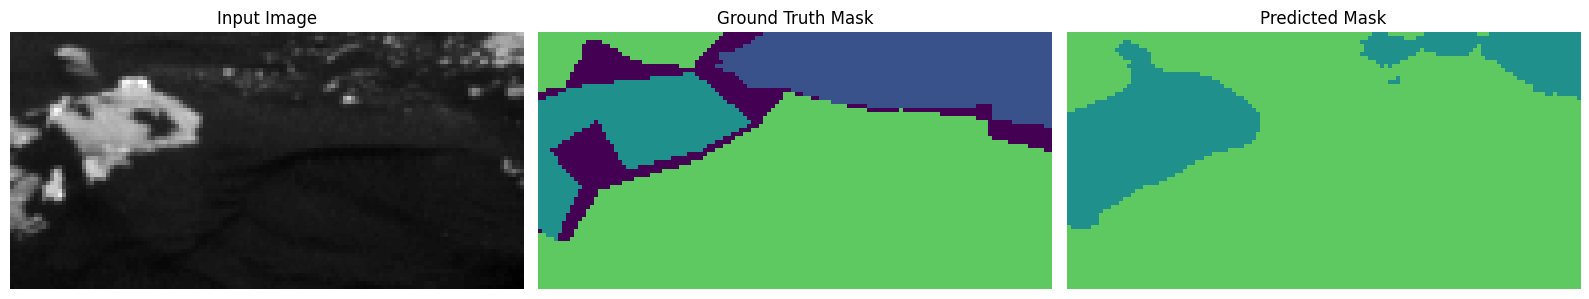

9/9 - 4s - 415ms/step - accuracy: 0.6994 - loss: 3.0474 - mean_iou: 0.6379 - val_accuracy: 0.6347 - val_loss: 3.2507 - val_mean_iou: 0.4298
Epoch 107/1000
9/9 - 3s - 377ms/step - accuracy: 0.7053 - loss: 3.0359 - mean_iou: 0.5170 - val_accuracy: 0.6443 - val_loss: 3.2034 - val_mean_iou: 0.4436
Epoch 108/1000
9/9 - 3s - 376ms/step - accuracy: 0.7086 - loss: 3.0329 - mean_iou: 0.5211 - val_accuracy: 0.6408 - val_loss: 3.1662 - val_mean_iou: 0.4205
Epoch 109/1000
9/9 - 3s - 377ms/step - accuracy: 0.7084 - loss: 3.0307 - mean_iou: 0.6564 - val_accuracy: 0.6304 - val_loss: 3.1890 - val_mean_iou: 0.4177
Epoch 110/1000
9/9 - 3s - 376ms/step - accuracy: 0.7075 - loss: 3.0329 - mean_iou: 0.6527 - val_accuracy: 0.6494 - val_loss: 3.1662 - val_mean_iou: 0.4310
Epoch 111/1000


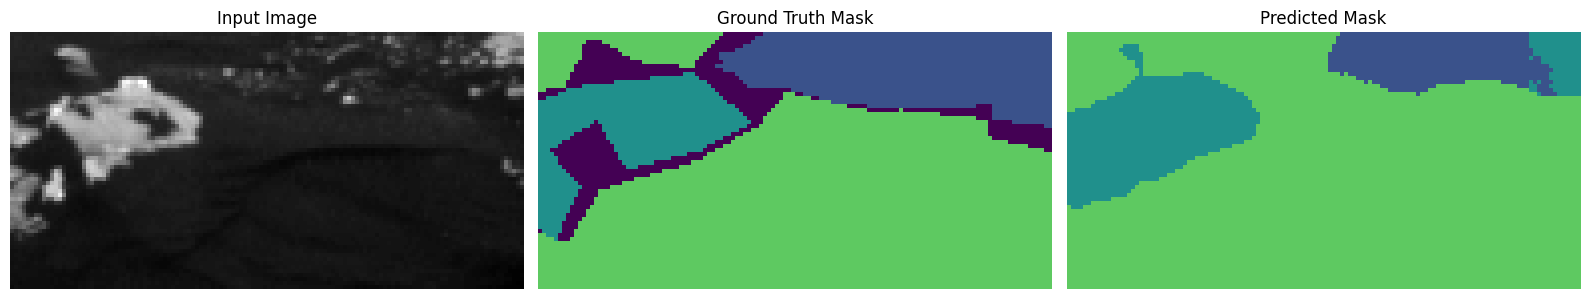

9/9 - 4s - 406ms/step - accuracy: 0.6968 - loss: 3.0499 - mean_iou: 0.5112 - val_accuracy: 0.6753 - val_loss: 3.0812 - val_mean_iou: 0.4796
Epoch 112/1000
9/9 - 3s - 376ms/step - accuracy: 0.7047 - loss: 3.0387 - mean_iou: 0.5199 - val_accuracy: 0.6574 - val_loss: 3.1406 - val_mean_iou: 0.5635
Epoch 113/1000
9/9 - 3s - 376ms/step - accuracy: 0.7116 - loss: 3.0282 - mean_iou: 0.5266 - val_accuracy: 0.6216 - val_loss: 3.1884 - val_mean_iou: 0.4881
Epoch 114/1000
9/9 - 3s - 376ms/step - accuracy: 0.7096 - loss: 3.0296 - mean_iou: 0.6558 - val_accuracy: 0.6411 - val_loss: 3.1640 - val_mean_iou: 0.5202
Epoch 115/1000
9/9 - 3s - 376ms/step - accuracy: 0.7075 - loss: 3.0334 - mean_iou: 0.5223 - val_accuracy: 0.6102 - val_loss: 3.2691 - val_mean_iou: 0.4813
Epoch 116/1000


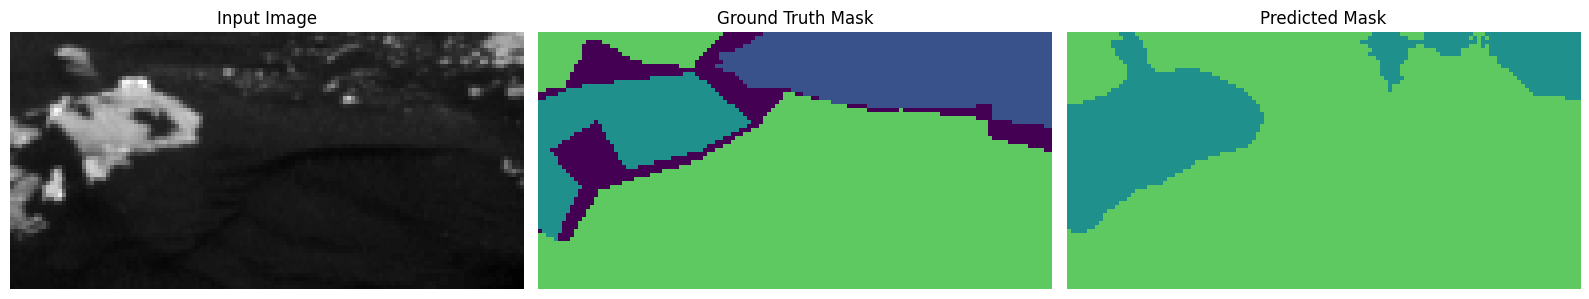

9/9 - 4s - 421ms/step - accuracy: 0.7073 - loss: 3.0320 - mean_iou: 0.5186 - val_accuracy: 0.6760 - val_loss: 3.1124 - val_mean_iou: 0.4793
Epoch 117/1000
9/9 - 3s - 377ms/step - accuracy: 0.7094 - loss: 3.0311 - mean_iou: 0.5265 - val_accuracy: 0.6038 - val_loss: 3.3271 - val_mean_iou: 0.4971
Epoch 118/1000
9/9 - 3s - 377ms/step - accuracy: 0.7088 - loss: 3.0301 - mean_iou: 0.5227 - val_accuracy: 0.5655 - val_loss: 3.4451 - val_mean_iou: 0.3686
Epoch 119/1000
9/9 - 3s - 376ms/step - accuracy: 0.7116 - loss: 3.0275 - mean_iou: 0.5253 - val_accuracy: 0.6736 - val_loss: 3.0953 - val_mean_iou: 0.5973
Epoch 120/1000
9/9 - 3s - 376ms/step - accuracy: 0.7124 - loss: 3.0260 - mean_iou: 0.5305 - val_accuracy: 0.6731 - val_loss: 3.1288 - val_mean_iou: 0.6013
Epoch 121/1000


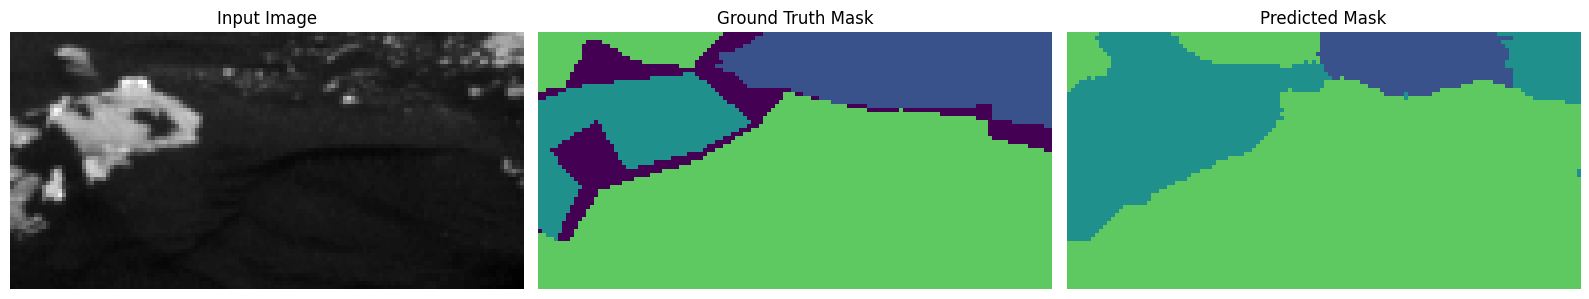

9/9 - 4s - 418ms/step - accuracy: 0.7095 - loss: 3.0319 - mean_iou: 0.5231 - val_accuracy: 0.6778 - val_loss: 3.1090 - val_mean_iou: 0.5916
Epoch 122/1000
9/9 - 3s - 376ms/step - accuracy: 0.7090 - loss: 3.0327 - mean_iou: 0.5219 - val_accuracy: 0.6556 - val_loss: 3.1491 - val_mean_iou: 0.5576
Epoch 123/1000
9/9 - 3s - 376ms/step - accuracy: 0.7077 - loss: 3.0312 - mean_iou: 0.5243 - val_accuracy: 0.6655 - val_loss: 3.1122 - val_mean_iou: 0.5740
Epoch 124/1000
9/9 - 3s - 383ms/step - accuracy: 0.7093 - loss: 3.0321 - mean_iou: 0.6564 - val_accuracy: 0.7155 - val_loss: 3.0208 - val_mean_iou: 0.6631
Epoch 125/1000
9/9 - 3s - 377ms/step - accuracy: 0.7106 - loss: 3.0248 - mean_iou: 0.6564 - val_accuracy: 0.6810 - val_loss: 3.0917 - val_mean_iou: 0.6020
Epoch 126/1000


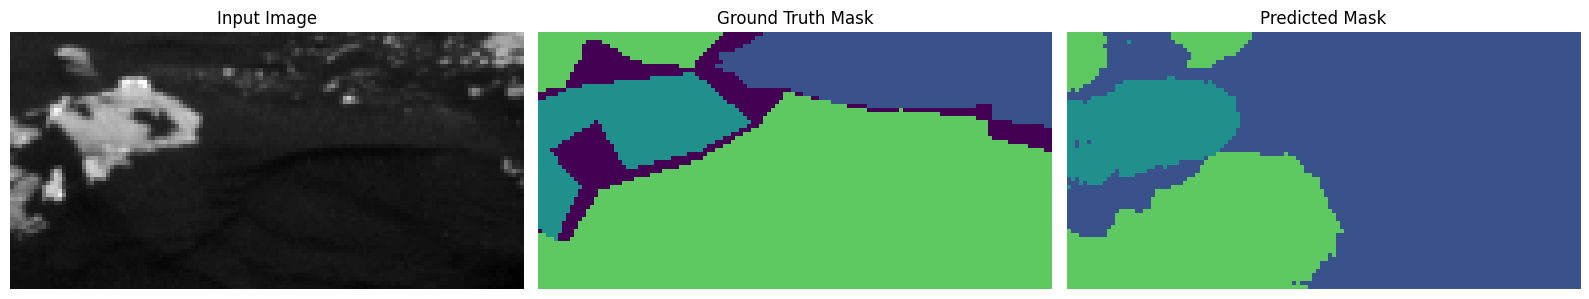

9/9 - 4s - 406ms/step - accuracy: 0.7115 - loss: 3.0258 - mean_iou: 0.5287 - val_accuracy: 0.6585 - val_loss: 3.1441 - val_mean_iou: 0.5598
Epoch 127/1000
9/9 - 3s - 377ms/step - accuracy: 0.7126 - loss: 3.0235 - mean_iou: 0.5313 - val_accuracy: 0.7050 - val_loss: 3.0390 - val_mean_iou: 0.5180
Epoch 128/1000
9/9 - 3s - 376ms/step - accuracy: 0.7112 - loss: 3.0240 - mean_iou: 0.5284 - val_accuracy: 0.7094 - val_loss: 3.0328 - val_mean_iou: 0.6551
Epoch 129/1000
9/9 - 3s - 377ms/step - accuracy: 0.7124 - loss: 3.0239 - mean_iou: 0.5282 - val_accuracy: 0.6872 - val_loss: 3.0791 - val_mean_iou: 0.6099
Epoch 130/1000
9/9 - 3s - 376ms/step - accuracy: 0.7120 - loss: 3.0243 - mean_iou: 0.5315 - val_accuracy: 0.6750 - val_loss: 3.0932 - val_mean_iou: 0.5923
Epoch 131/1000


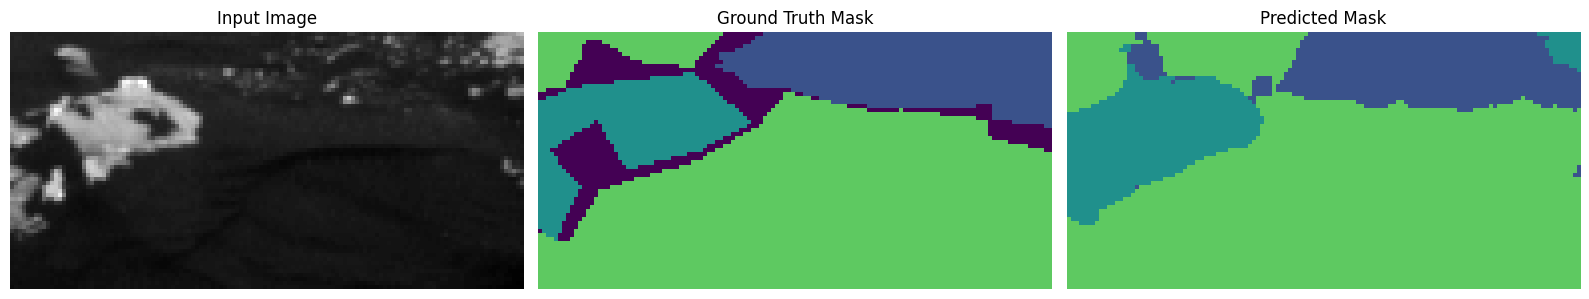

9/9 - 4s - 406ms/step - accuracy: 0.7073 - loss: 3.0331 - mean_iou: 0.5204 - val_accuracy: 0.6799 - val_loss: 3.1140 - val_mean_iou: 0.6080
Epoch 132/1000
9/9 - 3s - 377ms/step - accuracy: 0.7101 - loss: 3.0274 - mean_iou: 0.6570 - val_accuracy: 0.6942 - val_loss: 3.0621 - val_mean_iou: 0.6262
Epoch 133/1000
9/9 - 3s - 376ms/step - accuracy: 0.7183 - loss: 3.0137 - mean_iou: 0.6724 - val_accuracy: 0.6955 - val_loss: 3.0601 - val_mean_iou: 0.5067
Epoch 134/1000
9/9 - 3s - 377ms/step - accuracy: 0.7096 - loss: 3.0295 - mean_iou: 0.6592 - val_accuracy: 0.6995 - val_loss: 3.0495 - val_mean_iou: 0.5105
Epoch 135/1000
9/9 - 3s - 379ms/step - accuracy: 0.7174 - loss: 3.0158 - mean_iou: 0.5393 - val_accuracy: 0.7008 - val_loss: 3.0529 - val_mean_iou: 0.6398
Epoch 136/1000


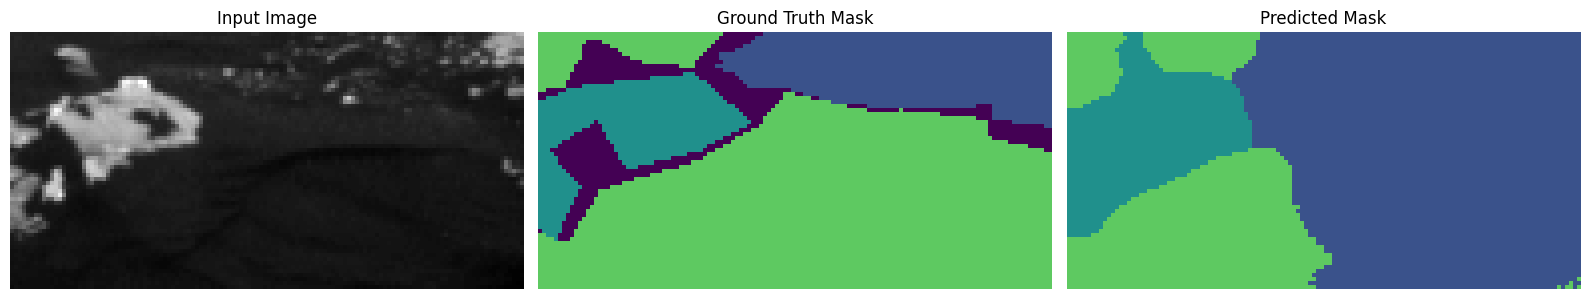

9/9 - 4s - 406ms/step - accuracy: 0.7173 - loss: 3.0148 - mean_iou: 0.5344 - val_accuracy: 0.6681 - val_loss: 3.1183 - val_mean_iou: 0.5680
Epoch 137/1000
9/9 - 3s - 377ms/step - accuracy: 0.7198 - loss: 3.0089 - mean_iou: 0.6744 - val_accuracy: 0.7014 - val_loss: 3.0452 - val_mean_iou: 0.6365
Epoch 138/1000
9/9 - 3s - 376ms/step - accuracy: 0.7235 - loss: 3.0049 - mean_iou: 0.6810 - val_accuracy: 0.7121 - val_loss: 3.0265 - val_mean_iou: 0.6555
Epoch 139/1000
9/9 - 3s - 376ms/step - accuracy: 0.7230 - loss: 3.0031 - mean_iou: 0.6814 - val_accuracy: 0.6908 - val_loss: 3.0672 - val_mean_iou: 0.6139
Epoch 140/1000
9/9 - 3s - 382ms/step - accuracy: 0.7205 - loss: 3.0113 - mean_iou: 0.5400 - val_accuracy: 0.7193 - val_loss: 3.0178 - val_mean_iou: 0.6701
Epoch 141/1000


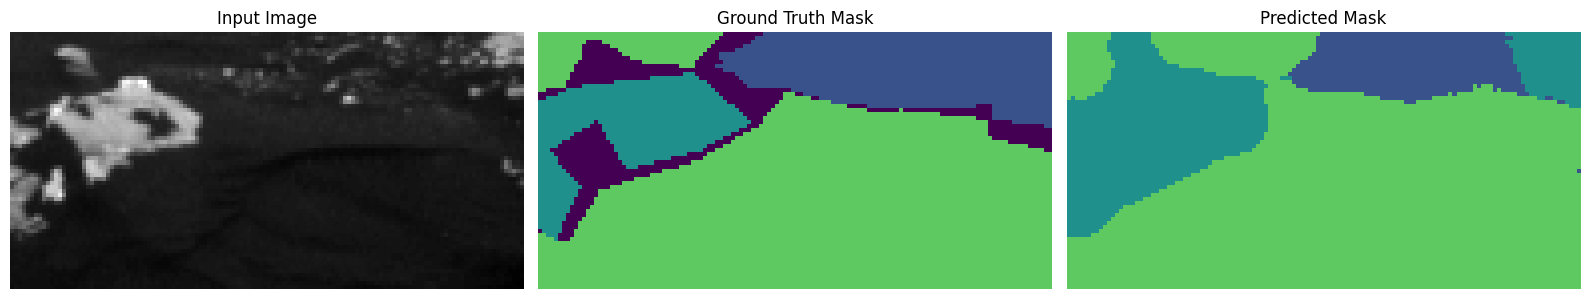

9/9 - 4s - 407ms/step - accuracy: 0.7230 - loss: 3.0045 - mean_iou: 0.5461 - val_accuracy: 0.7065 - val_loss: 3.0472 - val_mean_iou: 0.6499
Epoch 142/1000
9/9 - 3s - 377ms/step - accuracy: 0.7225 - loss: 3.0034 - mean_iou: 0.6804 - val_accuracy: 0.6908 - val_loss: 3.0860 - val_mean_iou: 0.6142
Epoch 143/1000
9/9 - 3s - 377ms/step - accuracy: 0.7204 - loss: 3.0100 - mean_iou: 0.6766 - val_accuracy: 0.6748 - val_loss: 3.1158 - val_mean_iou: 0.5945
Epoch 144/1000
9/9 - 3s - 377ms/step - accuracy: 0.7092 - loss: 3.0328 - mean_iou: 0.5248 - val_accuracy: 0.6826 - val_loss: 3.0919 - val_mean_iou: 0.6080
Epoch 145/1000
9/9 - 3s - 376ms/step - accuracy: 0.7138 - loss: 3.0174 - mean_iou: 0.5297 - val_accuracy: 0.5131 - val_loss: 3.8132 - val_mean_iou: 0.4030
Epoch 146/1000


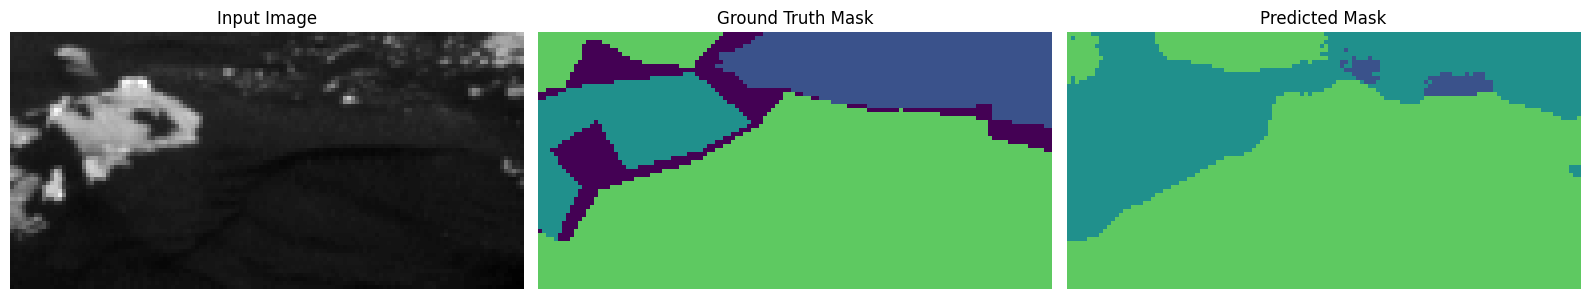

9/9 - 4s - 408ms/step - accuracy: 0.7106 - loss: 3.0307 - mean_iou: 0.6558 - val_accuracy: 0.5354 - val_loss: 3.6291 - val_mean_iou: 0.4343
Epoch 147/1000
9/9 - 3s - 377ms/step - accuracy: 0.7129 - loss: 3.0227 - mean_iou: 0.5312 - val_accuracy: 0.6759 - val_loss: 3.1078 - val_mean_iou: 0.6032
Epoch 148/1000
9/9 - 3s - 377ms/step - accuracy: 0.7080 - loss: 3.0302 - mean_iou: 0.6578 - val_accuracy: 0.6607 - val_loss: 3.1594 - val_mean_iou: 0.4518
Epoch 149/1000
9/9 - 3s - 377ms/step - accuracy: 0.7134 - loss: 3.0214 - mean_iou: 0.6631 - val_accuracy: 0.6447 - val_loss: 3.2865 - val_mean_iou: 0.4503
Epoch 150/1000
9/9 - 3s - 377ms/step - accuracy: 0.7206 - loss: 3.0095 - mean_iou: 0.5412 - val_accuracy: 0.6403 - val_loss: 3.2881 - val_mean_iou: 0.4463
Epoch 151/1000


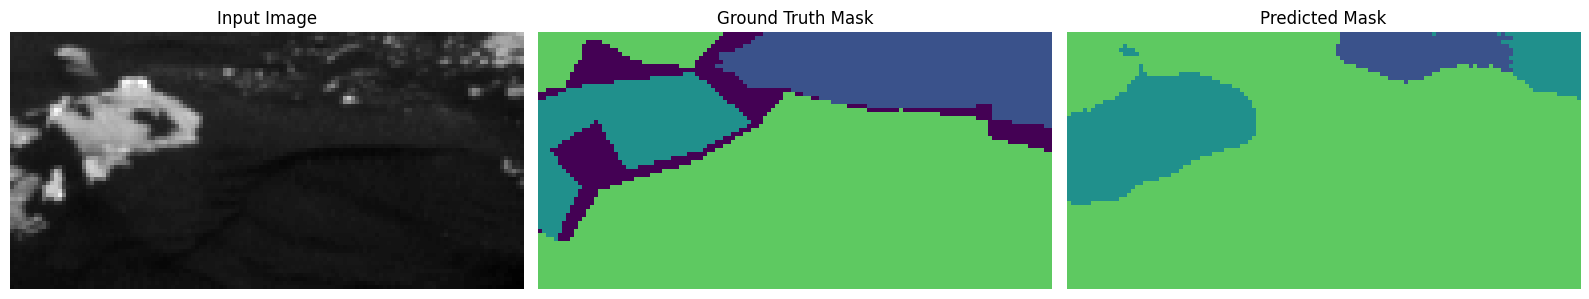

9/9 - 4s - 407ms/step - accuracy: 0.7241 - loss: 3.0036 - mean_iou: 0.5492 - val_accuracy: 0.7065 - val_loss: 3.0760 - val_mean_iou: 0.5238
Epoch 152/1000
9/9 - 3s - 377ms/step - accuracy: 0.7256 - loss: 2.9994 - mean_iou: 0.6859 - val_accuracy: 0.7116 - val_loss: 3.0326 - val_mean_iou: 0.5287
Epoch 153/1000
9/9 - 3s - 377ms/step - accuracy: 0.7222 - loss: 3.0053 - mean_iou: 0.6816 - val_accuracy: 0.7014 - val_loss: 3.0506 - val_mean_iou: 0.6363
Epoch 154/1000
9/9 - 3s - 377ms/step - accuracy: 0.7251 - loss: 3.0023 - mean_iou: 0.5498 - val_accuracy: 0.6973 - val_loss: 3.0550 - val_mean_iou: 0.6365
Epoch 155/1000
9/9 - 3s - 377ms/step - accuracy: 0.7196 - loss: 3.0093 - mean_iou: 0.5396 - val_accuracy: 0.6638 - val_loss: 3.1263 - val_mean_iou: 0.5672
Epoch 156/1000


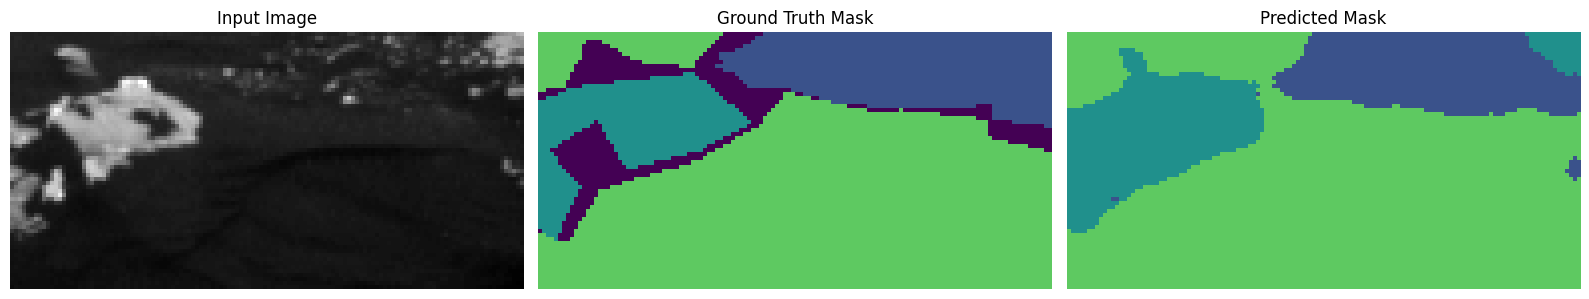

9/9 - 4s - 421ms/step - accuracy: 0.7218 - loss: 3.0049 - mean_iou: 0.6800 - val_accuracy: 0.7293 - val_loss: 2.9950 - val_mean_iou: 0.6932
Epoch 157/1000
9/9 - 3s - 377ms/step - accuracy: 0.7223 - loss: 3.0059 - mean_iou: 0.6830 - val_accuracy: 0.6844 - val_loss: 3.0973 - val_mean_iou: 0.6111
Epoch 158/1000
9/9 - 3s - 377ms/step - accuracy: 0.7185 - loss: 3.0120 - mean_iou: 0.6724 - val_accuracy: 0.6961 - val_loss: 3.0630 - val_mean_iou: 0.6344
Epoch 159/1000
9/9 - 3s - 377ms/step - accuracy: 0.7227 - loss: 3.0025 - mean_iou: 0.6825 - val_accuracy: 0.6275 - val_loss: 3.2057 - val_mean_iou: 0.4994
Epoch 160/1000
9/9 - 3s - 377ms/step - accuracy: 0.7232 - loss: 3.0042 - mean_iou: 0.6799 - val_accuracy: 0.7056 - val_loss: 3.0407 - val_mean_iou: 0.6506
Epoch 161/1000


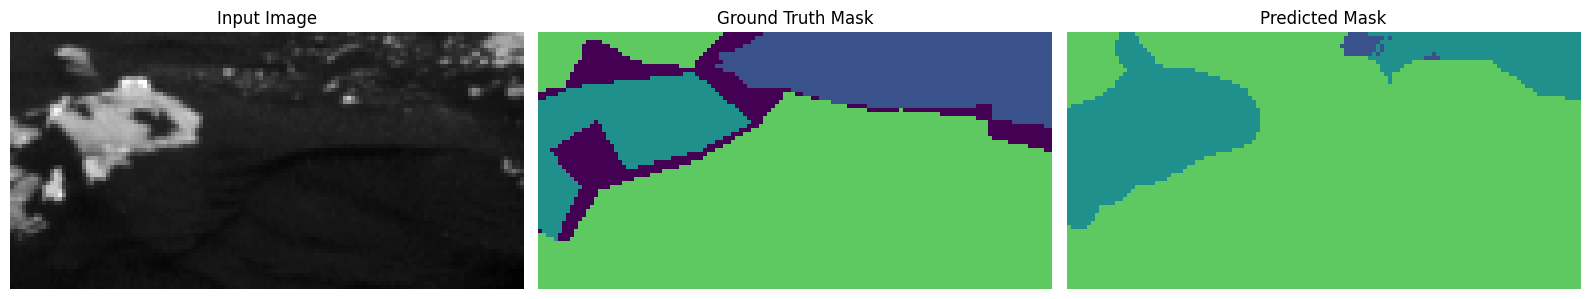

9/9 - 4s - 416ms/step - accuracy: 0.7237 - loss: 3.0011 - mean_iou: 0.6858 - val_accuracy: 0.6886 - val_loss: 3.0840 - val_mean_iou: 0.6259
Epoch 162/1000
9/9 - 3s - 378ms/step - accuracy: 0.7231 - loss: 3.0047 - mean_iou: 0.6874 - val_accuracy: 0.7257 - val_loss: 3.0075 - val_mean_iou: 0.6869
Epoch 163/1000
9/9 - 3s - 377ms/step - accuracy: 0.7269 - loss: 2.9982 - mean_iou: 0.6873 - val_accuracy: 0.7161 - val_loss: 3.0129 - val_mean_iou: 0.6652
Epoch 164/1000
9/9 - 3s - 376ms/step - accuracy: 0.7258 - loss: 2.9989 - mean_iou: 0.6840 - val_accuracy: 0.7060 - val_loss: 3.0389 - val_mean_iou: 0.6465
Epoch 165/1000
9/9 - 3s - 377ms/step - accuracy: 0.7263 - loss: 2.9974 - mean_iou: 0.6876 - val_accuracy: 0.7042 - val_loss: 3.0356 - val_mean_iou: 0.6437
Epoch 166/1000


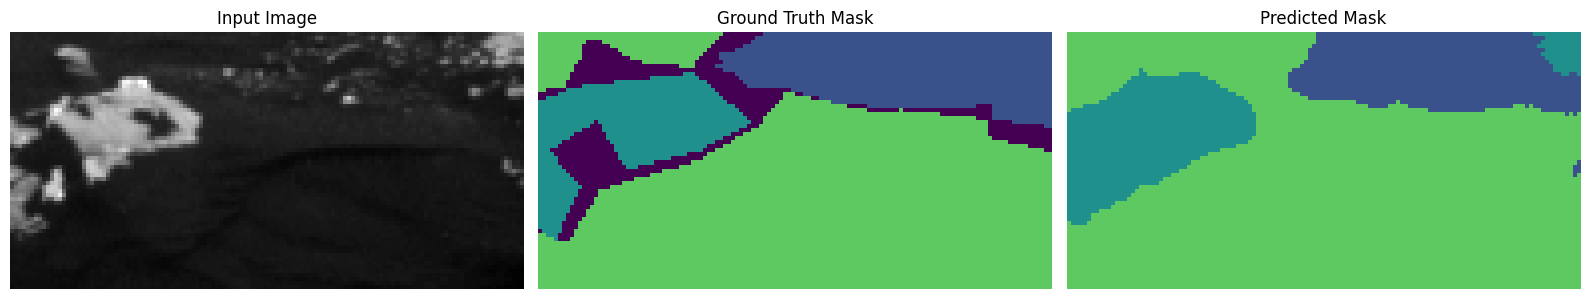

9/9 - 4s - 406ms/step - accuracy: 0.7299 - loss: 2.9928 - mean_iou: 0.6942 - val_accuracy: 0.7083 - val_loss: 3.0354 - val_mean_iou: 0.6497
Epoch 167/1000
9/9 - 3s - 377ms/step - accuracy: 0.7287 - loss: 2.9938 - mean_iou: 0.6964 - val_accuracy: 0.7070 - val_loss: 3.0307 - val_mean_iou: 0.6525
Epoch 168/1000
9/9 - 3s - 376ms/step - accuracy: 0.7283 - loss: 2.9947 - mean_iou: 0.6957 - val_accuracy: 0.7287 - val_loss: 2.9939 - val_mean_iou: 0.6904
Epoch 169/1000
9/9 - 3s - 377ms/step - accuracy: 0.7206 - loss: 3.0072 - mean_iou: 0.6800 - val_accuracy: 0.6169 - val_loss: 3.3229 - val_mean_iou: 0.5151
Epoch 170/1000
9/9 - 3s - 377ms/step - accuracy: 0.7254 - loss: 3.0008 - mean_iou: 0.6922 - val_accuracy: 0.6273 - val_loss: 3.2918 - val_mean_iou: 0.5311
Epoch 171/1000


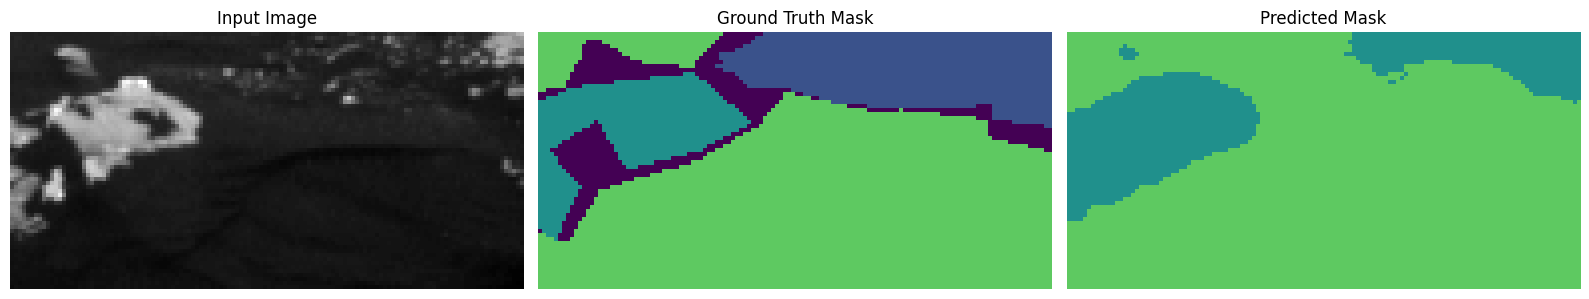

9/9 - 4s - 406ms/step - accuracy: 0.7262 - loss: 2.9972 - mean_iou: 0.6935 - val_accuracy: 0.6660 - val_loss: 3.1850 - val_mean_iou: 0.5865
Epoch 172/1000
9/9 - 3s - 376ms/step - accuracy: 0.7291 - loss: 2.9934 - mean_iou: 0.6920 - val_accuracy: 0.7182 - val_loss: 3.0166 - val_mean_iou: 0.6748
Epoch 173/1000
9/9 - 3s - 383ms/step - accuracy: 0.7311 - loss: 2.9895 - mean_iou: 0.6998 - val_accuracy: 0.7307 - val_loss: 2.9924 - val_mean_iou: 0.6973
Epoch 174/1000
9/9 - 3s - 377ms/step - accuracy: 0.7262 - loss: 2.9992 - mean_iou: 0.6876 - val_accuracy: 0.7107 - val_loss: 3.0347 - val_mean_iou: 0.6601
Epoch 175/1000
9/9 - 3s - 377ms/step - accuracy: 0.7208 - loss: 3.0060 - mean_iou: 0.6812 - val_accuracy: 0.7089 - val_loss: 3.0376 - val_mean_iou: 0.6556
Epoch 176/1000


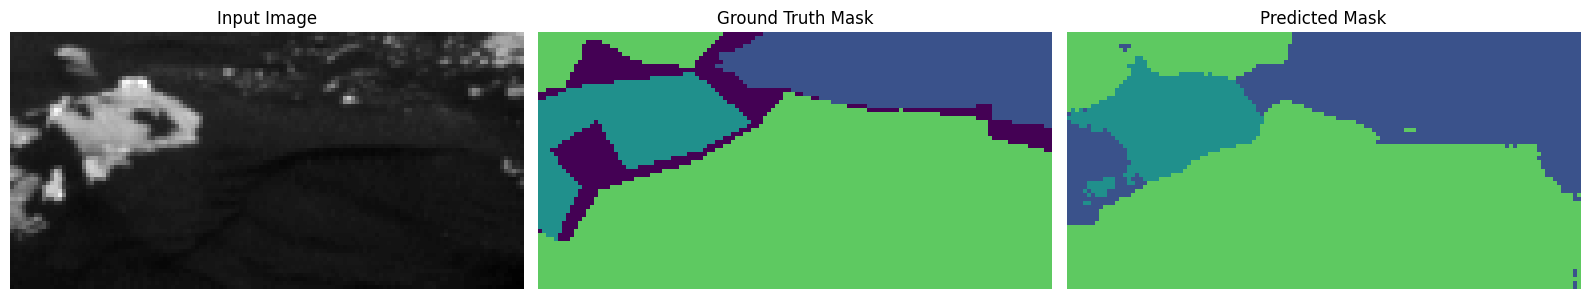

9/9 - 4s - 418ms/step - accuracy: 0.7231 - loss: 3.0055 - mean_iou: 0.6825 - val_accuracy: 0.6486 - val_loss: 3.1647 - val_mean_iou: 0.5564
Epoch 177/1000
9/9 - 3s - 377ms/step - accuracy: 0.7282 - loss: 2.9933 - mean_iou: 0.6914 - val_accuracy: 0.6774 - val_loss: 3.0891 - val_mean_iou: 0.5945
Epoch 178/1000
9/9 - 3s - 376ms/step - accuracy: 0.7290 - loss: 2.9920 - mean_iou: 0.6937 - val_accuracy: 0.7139 - val_loss: 3.0304 - val_mean_iou: 0.6731
Epoch 179/1000
9/9 - 3s - 377ms/step - accuracy: 0.7265 - loss: 2.9973 - mean_iou: 0.6942 - val_accuracy: 0.7276 - val_loss: 2.9969 - val_mean_iou: 0.6913
Epoch 180/1000
9/9 - 3s - 378ms/step - accuracy: 0.7255 - loss: 2.9990 - mean_iou: 0.6881 - val_accuracy: 0.7268 - val_loss: 2.9965 - val_mean_iou: 0.6899
Epoch 181/1000


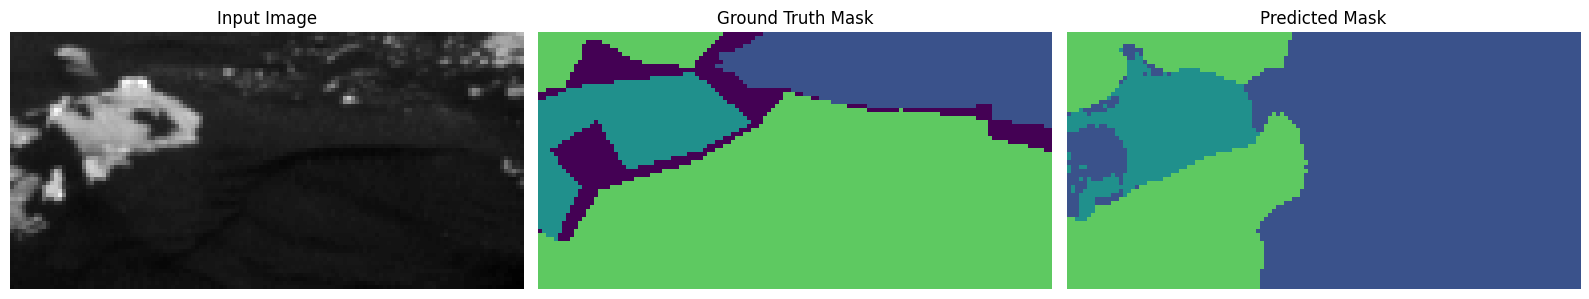

9/9 - 4s - 407ms/step - accuracy: 0.7277 - loss: 2.9945 - mean_iou: 0.6979 - val_accuracy: 0.6601 - val_loss: 3.1332 - val_mean_iou: 0.5754
Epoch 182/1000
9/9 - 3s - 377ms/step - accuracy: 0.7299 - loss: 2.9909 - mean_iou: 0.7024 - val_accuracy: 0.7242 - val_loss: 3.0068 - val_mean_iou: 0.6888
Epoch 183/1000
9/9 - 3s - 378ms/step - accuracy: 0.7258 - loss: 2.9980 - mean_iou: 0.6896 - val_accuracy: 0.7233 - val_loss: 3.0055 - val_mean_iou: 0.6790
Epoch 184/1000
9/9 - 3s - 377ms/step - accuracy: 0.7293 - loss: 2.9917 - mean_iou: 0.6985 - val_accuracy: 0.7088 - val_loss: 3.0446 - val_mean_iou: 0.6661
Epoch 185/1000
9/9 - 3s - 376ms/step - accuracy: 0.7288 - loss: 2.9933 - mean_iou: 0.7032 - val_accuracy: 0.7146 - val_loss: 3.0319 - val_mean_iou: 0.6708
Epoch 186/1000


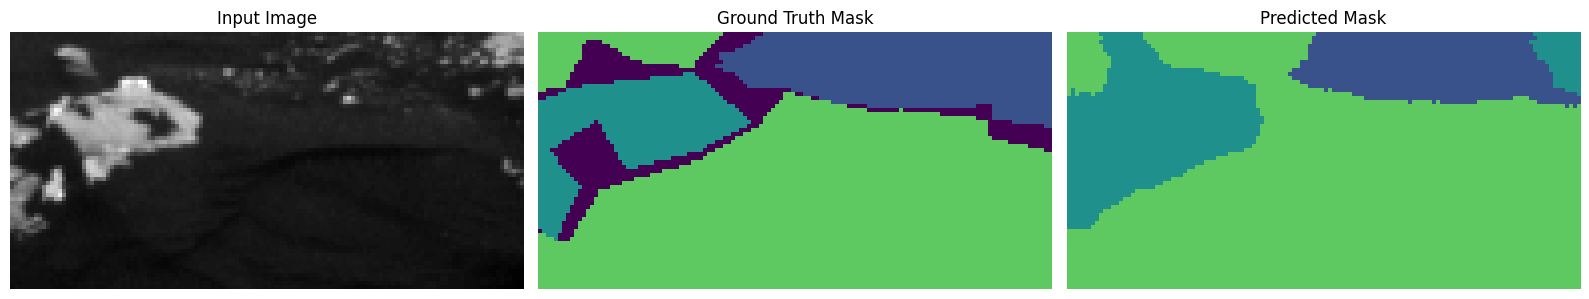

9/9 - 4s - 477ms/step - accuracy: 0.7212 - loss: 3.0085 - mean_iou: 0.6869 - val_accuracy: 0.6529 - val_loss: 3.1862 - val_mean_iou: 0.5649
Epoch 187/1000
9/9 - 3s - 377ms/step - accuracy: 0.7269 - loss: 2.9955 - mean_iou: 0.6936 - val_accuracy: 0.7019 - val_loss: 3.0409 - val_mean_iou: 0.6515
Epoch 188/1000
9/9 - 3s - 377ms/step - accuracy: 0.7262 - loss: 2.9968 - mean_iou: 0.6936 - val_accuracy: 0.6913 - val_loss: 3.0665 - val_mean_iou: 0.6265
Epoch 189/1000
9/9 - 3s - 378ms/step - accuracy: 0.7284 - loss: 2.9936 - mean_iou: 0.7030 - val_accuracy: 0.7251 - val_loss: 3.0039 - val_mean_iou: 0.6924
Epoch 190/1000
9/9 - 3s - 377ms/step - accuracy: 0.7198 - loss: 3.0122 - mean_iou: 0.6851 - val_accuracy: 0.7162 - val_loss: 3.0149 - val_mean_iou: 0.5512
Epoch 191/1000


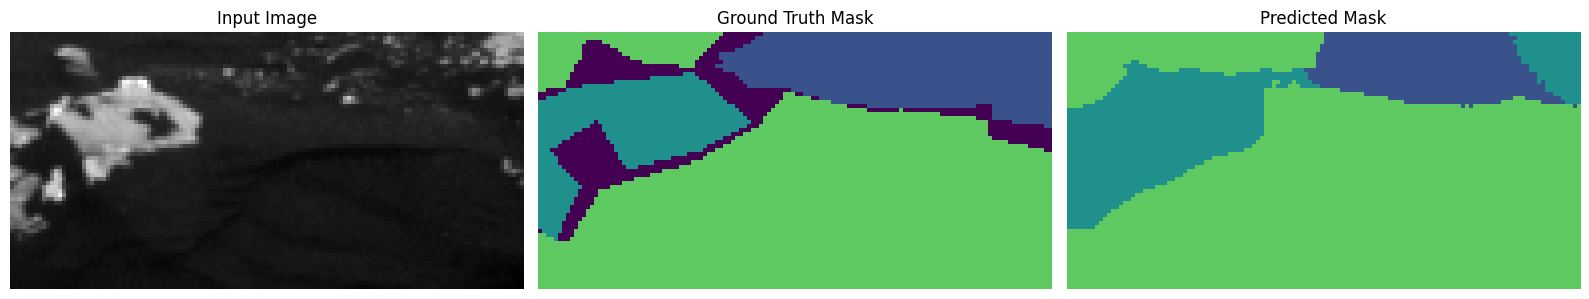

9/9 - 4s - 408ms/step - accuracy: 0.7240 - loss: 3.0028 - mean_iou: 0.6902 - val_accuracy: 0.7058 - val_loss: 3.0329 - val_mean_iou: 0.6558
Epoch 192/1000
9/9 - 3s - 377ms/step - accuracy: 0.7313 - loss: 2.9896 - mean_iou: 0.7136 - val_accuracy: 0.6939 - val_loss: 3.0719 - val_mean_iou: 0.6449
Epoch 193/1000
9/9 - 3s - 377ms/step - accuracy: 0.7292 - loss: 2.9928 - mean_iou: 0.6992 - val_accuracy: 0.7123 - val_loss: 3.0240 - val_mean_iou: 0.6681
Epoch 194/1000
9/9 - 3s - 377ms/step - accuracy: 0.7303 - loss: 2.9897 - mean_iou: 0.7079 - val_accuracy: 0.7149 - val_loss: 3.0190 - val_mean_iou: 0.6642
Epoch 195/1000
9/9 - 3s - 377ms/step - accuracy: 0.7298 - loss: 2.9908 - mean_iou: 0.7145 - val_accuracy: 0.7036 - val_loss: 3.0531 - val_mean_iou: 0.6562
Epoch 196/1000


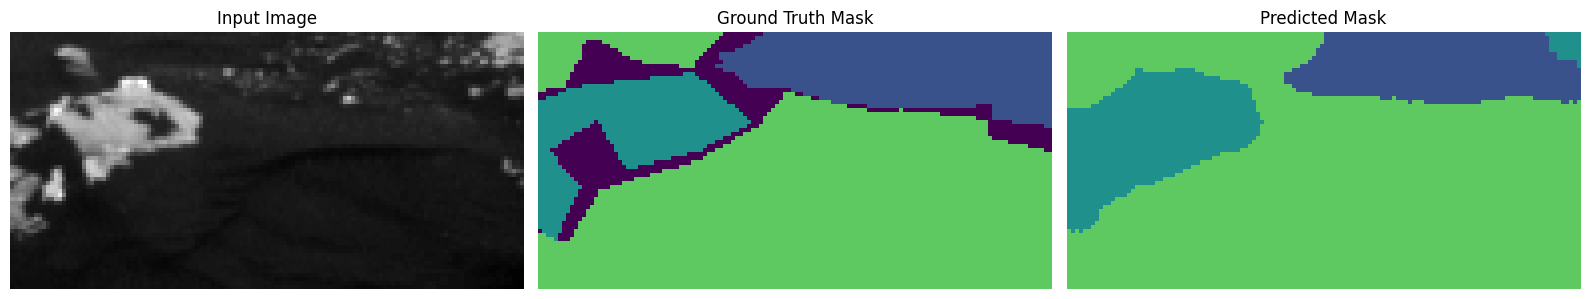

9/9 - 4s - 414ms/step - accuracy: 0.7315 - loss: 2.9897 - mean_iou: 0.7077 - val_accuracy: 0.7048 - val_loss: 3.0433 - val_mean_iou: 0.6585
Epoch 197/1000
9/9 - 3s - 382ms/step - accuracy: 0.7336 - loss: 2.9845 - mean_iou: 0.7238 - val_accuracy: 0.7320 - val_loss: 2.9886 - val_mean_iou: 0.7060
Epoch 198/1000
9/9 - 3s - 377ms/step - accuracy: 0.7330 - loss: 2.9856 - mean_iou: 0.7084 - val_accuracy: 0.6968 - val_loss: 3.0585 - val_mean_iou: 0.6316
Epoch 199/1000
9/9 - 3s - 377ms/step - accuracy: 0.7329 - loss: 2.9861 - mean_iou: 0.7141 - val_accuracy: 0.7109 - val_loss: 3.0393 - val_mean_iou: 0.6645
Epoch 200/1000
9/9 - 3s - 382ms/step - accuracy: 0.7324 - loss: 2.9853 - mean_iou: 0.7310 - val_accuracy: 0.7323 - val_loss: 2.9886 - val_mean_iou: 0.7141
Epoch 201/1000


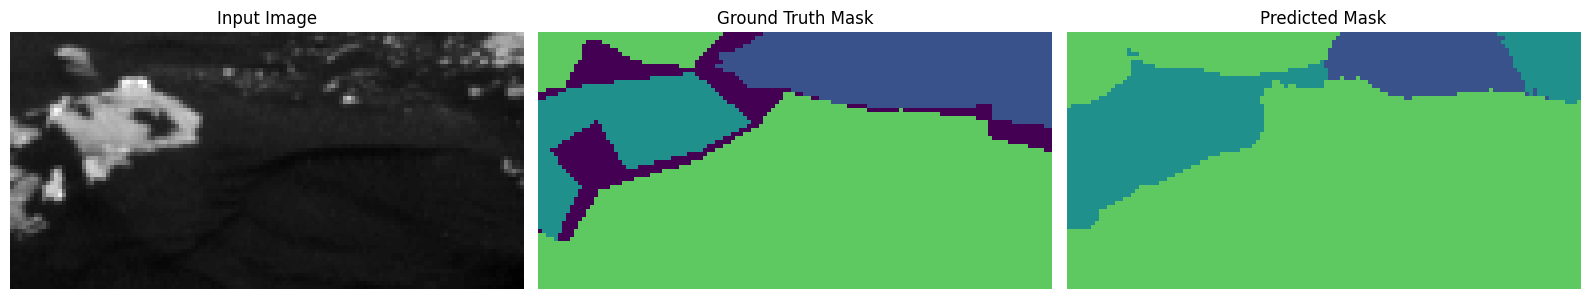

9/9 - 4s - 415ms/step - accuracy: 0.7334 - loss: 2.9847 - mean_iou: 0.7232 - val_accuracy: 0.6917 - val_loss: 3.0797 - val_mean_iou: 0.6489
Epoch 202/1000
9/9 - 3s - 377ms/step - accuracy: 0.7281 - loss: 2.9929 - mean_iou: 0.7181 - val_accuracy: 0.7130 - val_loss: 3.0328 - val_mean_iou: 0.6687
Epoch 203/1000
9/9 - 3s - 376ms/step - accuracy: 0.7267 - loss: 2.9960 - mean_iou: 0.7037 - val_accuracy: 0.6846 - val_loss: 3.1008 - val_mean_iou: 0.6251
Epoch 204/1000
9/9 - 3s - 377ms/step - accuracy: 0.7257 - loss: 2.9989 - mean_iou: 0.7083 - val_accuracy: 0.6360 - val_loss: 3.2997 - val_mean_iou: 0.5578
Epoch 205/1000
9/9 - 3s - 377ms/step - accuracy: 0.7285 - loss: 2.9940 - mean_iou: 0.7120 - val_accuracy: 0.6423 - val_loss: 3.2428 - val_mean_iou: 0.5658
Epoch 206/1000


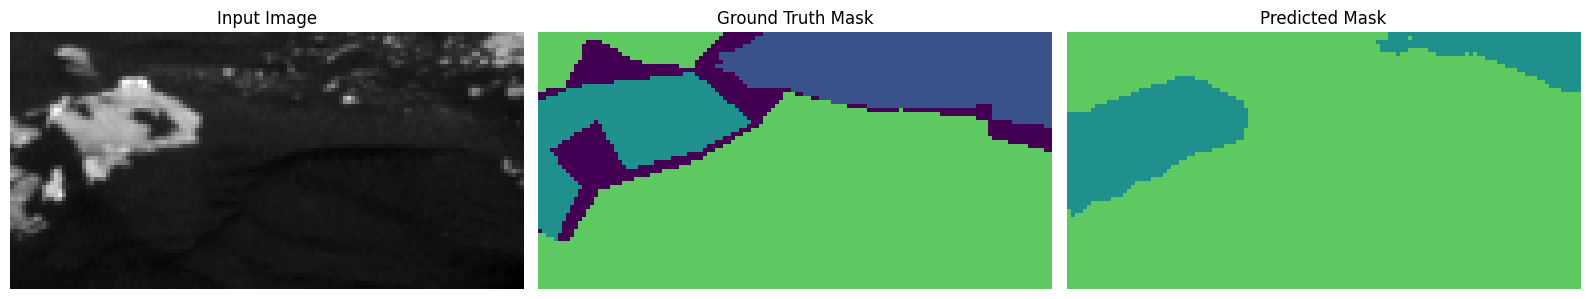

9/9 - 4s - 406ms/step - accuracy: 0.7248 - loss: 3.0009 - mean_iou: 0.6953 - val_accuracy: 0.4445 - val_loss: 4.0517 - val_mean_iou: 0.2484
Epoch 207/1000
9/9 - 3s - 378ms/step - accuracy: 0.7250 - loss: 2.9997 - mean_iou: 0.6997 - val_accuracy: 0.6818 - val_loss: 3.1441 - val_mean_iou: 0.6186
Epoch 208/1000
9/9 - 3s - 378ms/step - accuracy: 0.7293 - loss: 2.9907 - mean_iou: 0.7054 - val_accuracy: 0.7054 - val_loss: 3.0684 - val_mean_iou: 0.6561
Epoch 209/1000
9/9 - 3s - 377ms/step - accuracy: 0.7293 - loss: 2.9913 - mean_iou: 0.7156 - val_accuracy: 0.7015 - val_loss: 3.0601 - val_mean_iou: 0.6623
Epoch 210/1000
9/9 - 3s - 377ms/step - accuracy: 0.7293 - loss: 2.9915 - mean_iou: 0.7177 - val_accuracy: 0.6858 - val_loss: 3.0896 - val_mean_iou: 0.6349
Epoch 211/1000


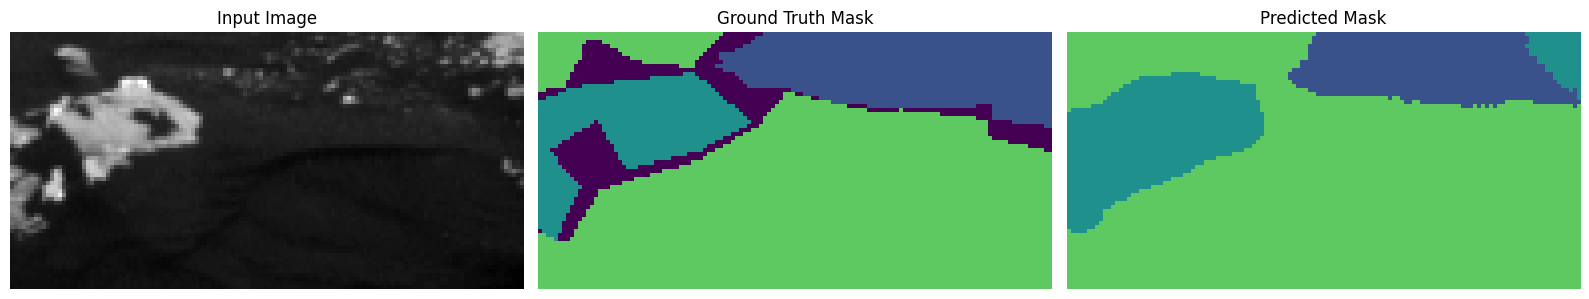

9/9 - 4s - 416ms/step - accuracy: 0.7345 - loss: 2.9827 - mean_iou: 0.7414 - val_accuracy: 0.7167 - val_loss: 3.0210 - val_mean_iou: 0.6980
Epoch 212/1000
9/9 - 3s - 377ms/step - accuracy: 0.7334 - loss: 2.9831 - mean_iou: 0.7354 - val_accuracy: 0.6686 - val_loss: 3.1169 - val_mean_iou: 0.6045
Epoch 213/1000
9/9 - 3s - 377ms/step - accuracy: 0.7334 - loss: 2.9825 - mean_iou: 0.7229 - val_accuracy: 0.7182 - val_loss: 3.0265 - val_mean_iou: 0.6999
Epoch 214/1000
9/9 - 3s - 377ms/step - accuracy: 0.7373 - loss: 2.9781 - mean_iou: 0.7512 - val_accuracy: 0.7169 - val_loss: 3.0237 - val_mean_iou: 0.6816
Epoch 215/1000
9/9 - 3s - 377ms/step - accuracy: 0.7345 - loss: 2.9818 - mean_iou: 0.7348 - val_accuracy: 0.7236 - val_loss: 3.0011 - val_mean_iou: 0.6961
Epoch 216/1000


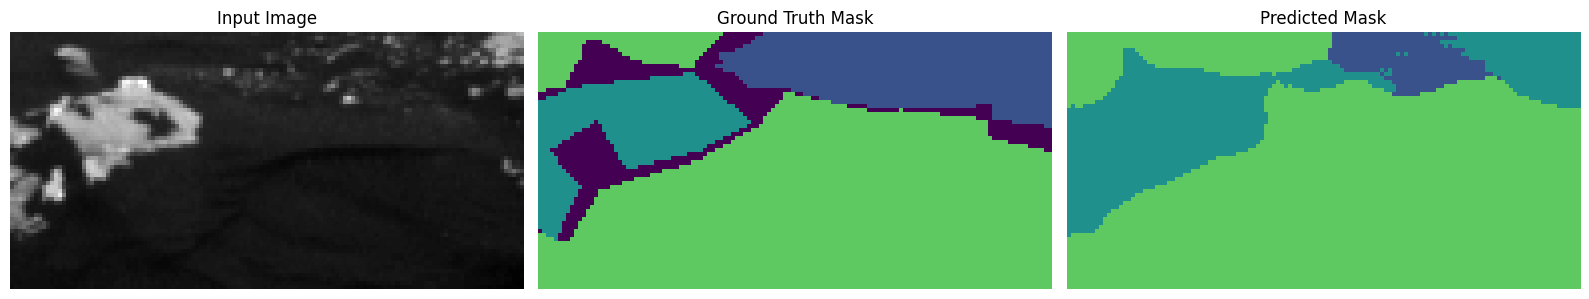

9/9 - 4s - 417ms/step - accuracy: 0.7343 - loss: 2.9815 - mean_iou: 0.7256 - val_accuracy: 0.7200 - val_loss: 3.0095 - val_mean_iou: 0.6915
Epoch 217/1000
9/9 - 3s - 383ms/step - accuracy: 0.7361 - loss: 2.9798 - mean_iou: 0.7422 - val_accuracy: 0.7330 - val_loss: 2.9880 - val_mean_iou: 0.7202
Epoch 218/1000
9/9 - 3s - 382ms/step - accuracy: 0.7377 - loss: 2.9761 - mean_iou: 0.7437 - val_accuracy: 0.7337 - val_loss: 2.9853 - val_mean_iou: 0.7396
Epoch 219/1000
9/9 - 3s - 377ms/step - accuracy: 0.7364 - loss: 2.9777 - mean_iou: 0.7497 - val_accuracy: 0.7280 - val_loss: 2.9956 - val_mean_iou: 0.7061
Epoch 220/1000
9/9 - 3s - 377ms/step - accuracy: 0.7370 - loss: 2.9780 - mean_iou: 0.7338 - val_accuracy: 0.7295 - val_loss: 2.9933 - val_mean_iou: 0.7241
Epoch 221/1000


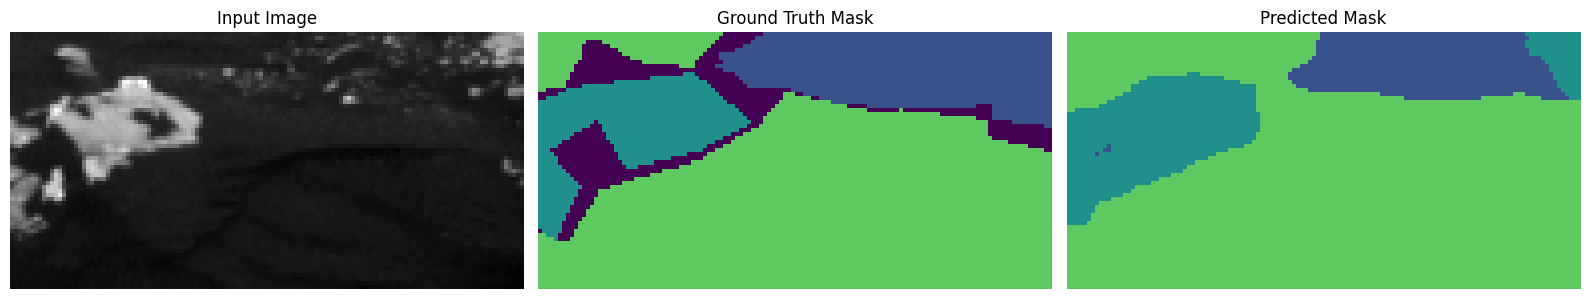

9/9 - 4s - 423ms/step - accuracy: 0.7389 - loss: 2.9738 - mean_iou: 0.7567 - val_accuracy: 0.7387 - val_loss: 2.9748 - val_mean_iou: 0.7476
Epoch 222/1000
9/9 - 3s - 377ms/step - accuracy: 0.7386 - loss: 2.9732 - mean_iou: 0.7588 - val_accuracy: 0.7378 - val_loss: 2.9768 - val_mean_iou: 0.7250
Epoch 223/1000
9/9 - 3s - 377ms/step - accuracy: 0.7368 - loss: 2.9786 - mean_iou: 0.7309 - val_accuracy: 0.7308 - val_loss: 2.9888 - val_mean_iou: 0.7357
Epoch 224/1000
9/9 - 3s - 378ms/step - accuracy: 0.7377 - loss: 2.9773 - mean_iou: 0.7607 - val_accuracy: 0.7355 - val_loss: 2.9817 - val_mean_iou: 0.7538
Epoch 225/1000
9/9 - 3s - 384ms/step - accuracy: 0.7407 - loss: 2.9703 - mean_iou: 0.7640 - val_accuracy: 0.7423 - val_loss: 2.9680 - val_mean_iou: 0.7239
Epoch 226/1000


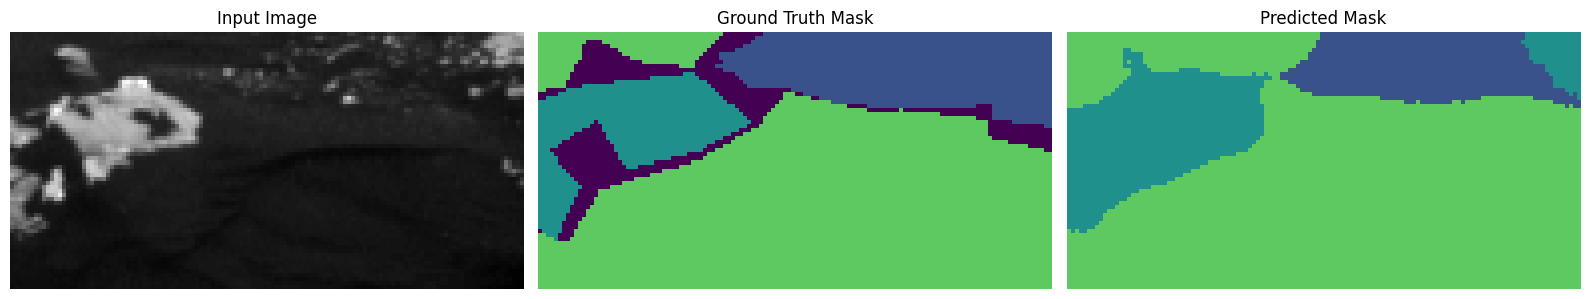

9/9 - 4s - 409ms/step - accuracy: 0.7374 - loss: 2.9758 - mean_iou: 0.7381 - val_accuracy: 0.7385 - val_loss: 2.9771 - val_mean_iou: 0.7320
Epoch 227/1000
9/9 - 3s - 377ms/step - accuracy: 0.7326 - loss: 2.9880 - mean_iou: 0.7148 - val_accuracy: 0.6793 - val_loss: 3.0919 - val_mean_iou: 0.6249
Epoch 228/1000
9/9 - 3s - 378ms/step - accuracy: 0.7328 - loss: 2.9859 - mean_iou: 0.7271 - val_accuracy: 0.7324 - val_loss: 2.9875 - val_mean_iou: 0.7261
Epoch 229/1000
9/9 - 3s - 377ms/step - accuracy: 0.7336 - loss: 2.9822 - mean_iou: 0.7320 - val_accuracy: 0.7274 - val_loss: 2.9949 - val_mean_iou: 0.7037
Epoch 230/1000
9/9 - 3s - 376ms/step - accuracy: 0.7351 - loss: 2.9802 - mean_iou: 0.7336 - val_accuracy: 0.7387 - val_loss: 2.9790 - val_mean_iou: 0.7435
Epoch 231/1000


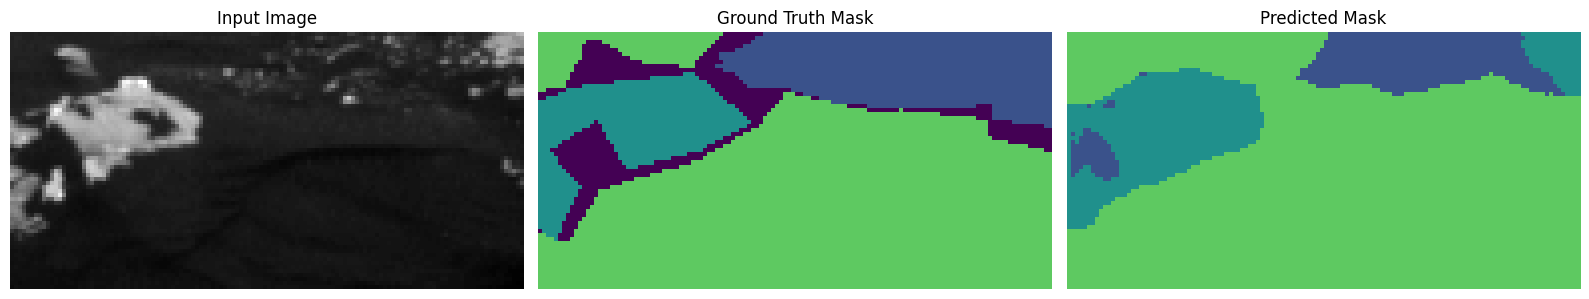

9/9 - 4s - 407ms/step - accuracy: 0.7332 - loss: 2.9819 - mean_iou: 0.7429 - val_accuracy: 0.7173 - val_loss: 3.0293 - val_mean_iou: 0.7153
Epoch 232/1000
9/9 - 3s - 376ms/step - accuracy: 0.7377 - loss: 2.9767 - mean_iou: 0.7510 - val_accuracy: 0.7045 - val_loss: 3.0810 - val_mean_iou: 0.6838
Epoch 233/1000
9/9 - 3s - 376ms/step - accuracy: 0.7364 - loss: 2.9782 - mean_iou: 0.7249 - val_accuracy: 0.7365 - val_loss: 2.9794 - val_mean_iou: 0.7592
Epoch 234/1000
9/9 - 3s - 377ms/step - accuracy: 0.7377 - loss: 2.9776 - mean_iou: 0.7594 - val_accuracy: 0.7309 - val_loss: 2.9899 - val_mean_iou: 0.7457
Epoch 235/1000
9/9 - 3s - 378ms/step - accuracy: 0.7398 - loss: 2.9729 - mean_iou: 0.7580 - val_accuracy: 0.7402 - val_loss: 2.9698 - val_mean_iou: 0.7651
Epoch 236/1000


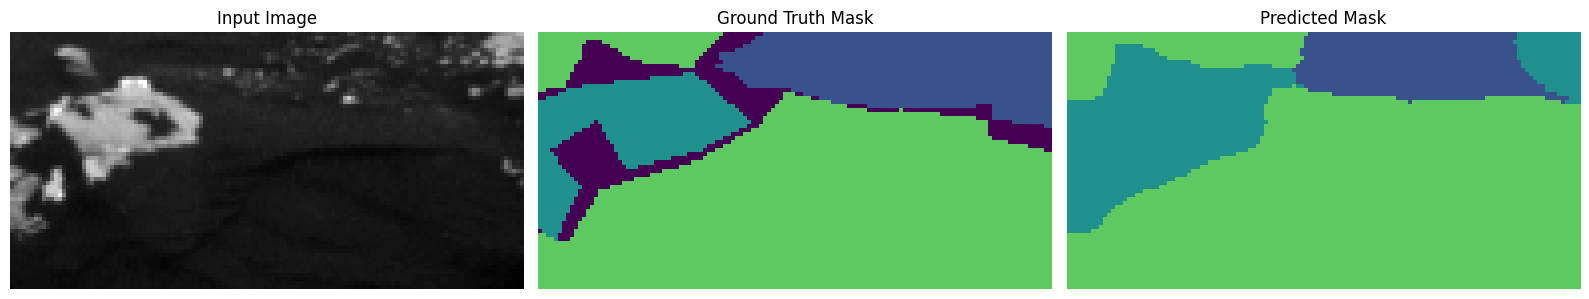

9/9 - 4s - 415ms/step - accuracy: 0.7396 - loss: 2.9716 - mean_iou: 0.7610 - val_accuracy: 0.7229 - val_loss: 3.0104 - val_mean_iou: 0.7170
Epoch 237/1000
9/9 - 3s - 376ms/step - accuracy: 0.7379 - loss: 2.9768 - mean_iou: 0.7594 - val_accuracy: 0.7326 - val_loss: 2.9896 - val_mean_iou: 0.7521
Epoch 238/1000
9/9 - 3s - 376ms/step - accuracy: 0.7385 - loss: 2.9727 - mean_iou: 0.7622 - val_accuracy: 0.7305 - val_loss: 2.9919 - val_mean_iou: 0.7133
Epoch 239/1000
9/9 - 3s - 376ms/step - accuracy: 0.7408 - loss: 2.9703 - mean_iou: 0.7609 - val_accuracy: 0.7159 - val_loss: 3.0097 - val_mean_iou: 0.7010
Epoch 240/1000
9/9 - 3s - 376ms/step - accuracy: 0.7383 - loss: 2.9750 - mean_iou: 0.7484 - val_accuracy: 0.7336 - val_loss: 2.9821 - val_mean_iou: 0.7613
Epoch 241/1000


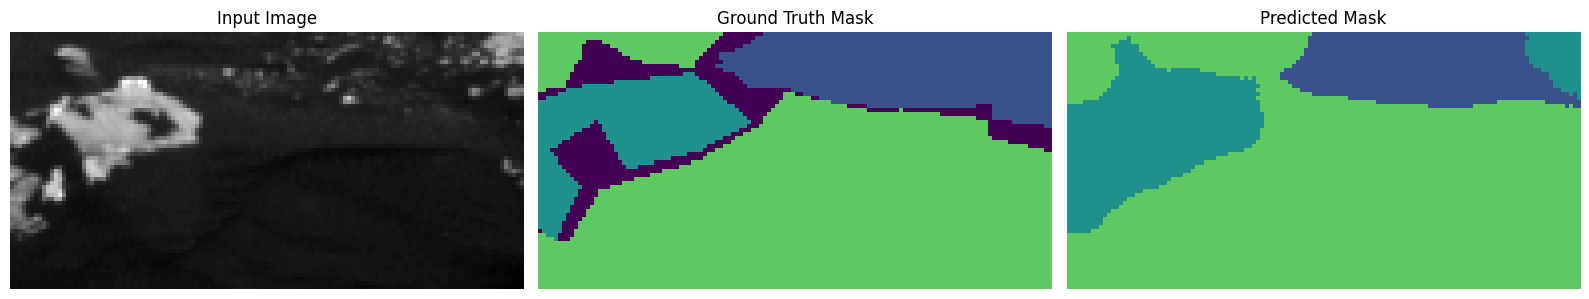

9/9 - 4s - 406ms/step - accuracy: 0.7344 - loss: 2.9840 - mean_iou: 0.7396 - val_accuracy: 0.7305 - val_loss: 2.9895 - val_mean_iou: 0.7137
Epoch 242/1000
9/9 - 3s - 376ms/step - accuracy: 0.7333 - loss: 2.9849 - mean_iou: 0.7554 - val_accuracy: 0.7131 - val_loss: 3.0248 - val_mean_iou: 0.7053
Epoch 243/1000
9/9 - 3s - 377ms/step - accuracy: 0.7351 - loss: 2.9805 - mean_iou: 0.7282 - val_accuracy: 0.7247 - val_loss: 3.0016 - val_mean_iou: 0.7002
Epoch 244/1000
9/9 - 3s - 377ms/step - accuracy: 0.7388 - loss: 2.9730 - mean_iou: 0.7565 - val_accuracy: 0.5549 - val_loss: 3.6878 - val_mean_iou: 0.4822
Epoch 245/1000
9/9 - 3s - 376ms/step - accuracy: 0.7341 - loss: 2.9819 - mean_iou: 0.7647 - val_accuracy: 0.7308 - val_loss: 2.9881 - val_mean_iou: 0.7226
Epoch 246/1000


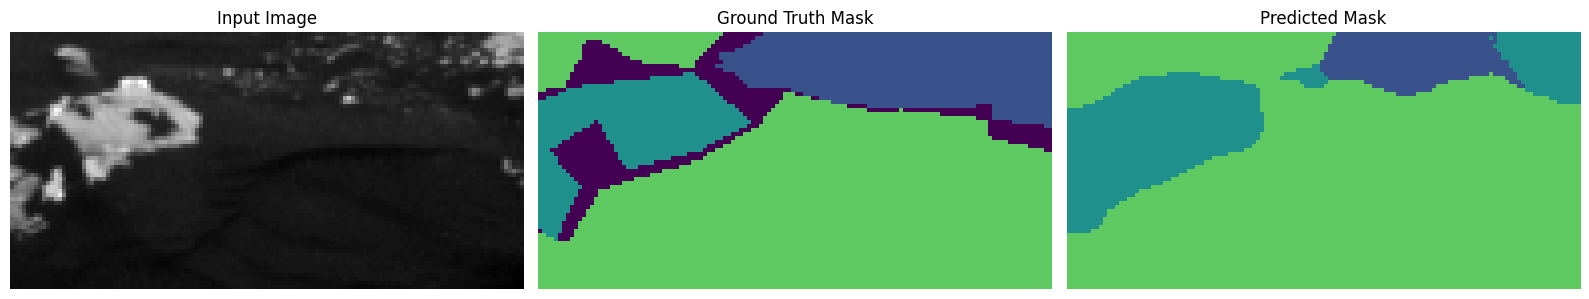

9/9 - 4s - 415ms/step - accuracy: 0.7352 - loss: 2.9803 - mean_iou: 0.7484 - val_accuracy: 0.7065 - val_loss: 3.0409 - val_mean_iou: 0.7198
Epoch 247/1000
9/9 - 3s - 376ms/step - accuracy: 0.7417 - loss: 2.9682 - mean_iou: 0.7701 - val_accuracy: 0.7382 - val_loss: 2.9736 - val_mean_iou: 0.7631
Epoch 248/1000
9/9 - 3s - 376ms/step - accuracy: 0.7402 - loss: 2.9710 - mean_iou: 0.7723 - val_accuracy: 0.7396 - val_loss: 2.9759 - val_mean_iou: 0.7631
Epoch 249/1000
9/9 - 3s - 377ms/step - accuracy: 0.7396 - loss: 2.9728 - mean_iou: 0.7692 - val_accuracy: 0.7343 - val_loss: 2.9797 - val_mean_iou: 0.7612
Epoch 250/1000
9/9 - 3s - 377ms/step - accuracy: 0.7415 - loss: 2.9692 - mean_iou: 0.7568 - val_accuracy: 0.7386 - val_loss: 2.9740 - val_mean_iou: 0.7633
Epoch 251/1000


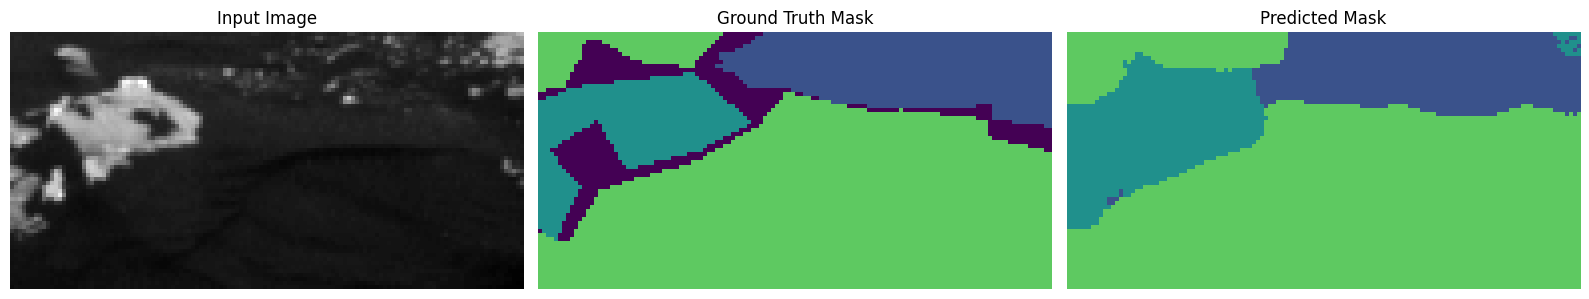

9/9 - 4s - 406ms/step - accuracy: 0.7435 - loss: 2.9652 - mean_iou: 0.7711 - val_accuracy: 0.7399 - val_loss: 2.9738 - val_mean_iou: 0.7772
Epoch 252/1000
9/9 - 3s - 382ms/step - accuracy: 0.7433 - loss: 2.9643 - mean_iou: 0.7803 - val_accuracy: 0.7438 - val_loss: 2.9644 - val_mean_iou: 0.7737
Epoch 253/1000
9/9 - 3s - 382ms/step - accuracy: 0.7433 - loss: 2.9645 - mean_iou: 0.7699 - val_accuracy: 0.7461 - val_loss: 2.9604 - val_mean_iou: 0.7757
Epoch 254/1000
9/9 - 3s - 376ms/step - accuracy: 0.7404 - loss: 2.9721 - mean_iou: 0.7689 - val_accuracy: 0.7396 - val_loss: 2.9719 - val_mean_iou: 0.7625
Epoch 255/1000
9/9 - 3s - 377ms/step - accuracy: 0.7396 - loss: 2.9726 - mean_iou: 0.7648 - val_accuracy: 0.7339 - val_loss: 2.9853 - val_mean_iou: 0.7372
Epoch 256/1000


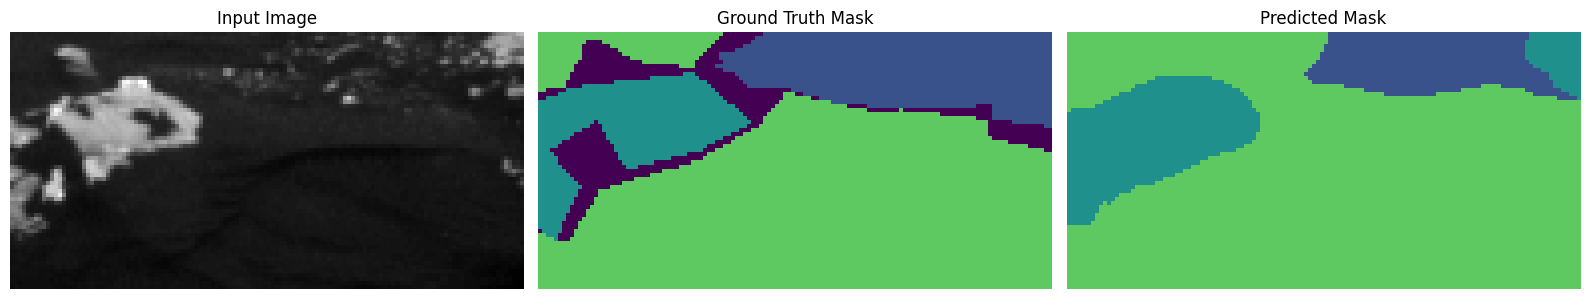

9/9 - 4s - 407ms/step - accuracy: 0.7381 - loss: 2.9755 - mean_iou: 0.7572 - val_accuracy: 0.7328 - val_loss: 2.9873 - val_mean_iou: 0.7591
Epoch 257/1000
9/9 - 3s - 377ms/step - accuracy: 0.7417 - loss: 2.9681 - mean_iou: 0.7797 - val_accuracy: 0.7380 - val_loss: 2.9769 - val_mean_iou: 0.7455
Epoch 258/1000
9/9 - 3s - 376ms/step - accuracy: 0.7428 - loss: 2.9657 - mean_iou: 0.7666 - val_accuracy: 0.7386 - val_loss: 2.9739 - val_mean_iou: 0.7667
Epoch 259/1000
9/9 - 3s - 377ms/step - accuracy: 0.7398 - loss: 2.9695 - mean_iou: 0.7788 - val_accuracy: 0.7329 - val_loss: 2.9836 - val_mean_iou: 0.7220
Epoch 260/1000
9/9 - 3s - 377ms/step - accuracy: 0.7370 - loss: 2.9776 - mean_iou: 0.7533 - val_accuracy: 0.7136 - val_loss: 3.0193 - val_mean_iou: 0.7123
Epoch 261/1000


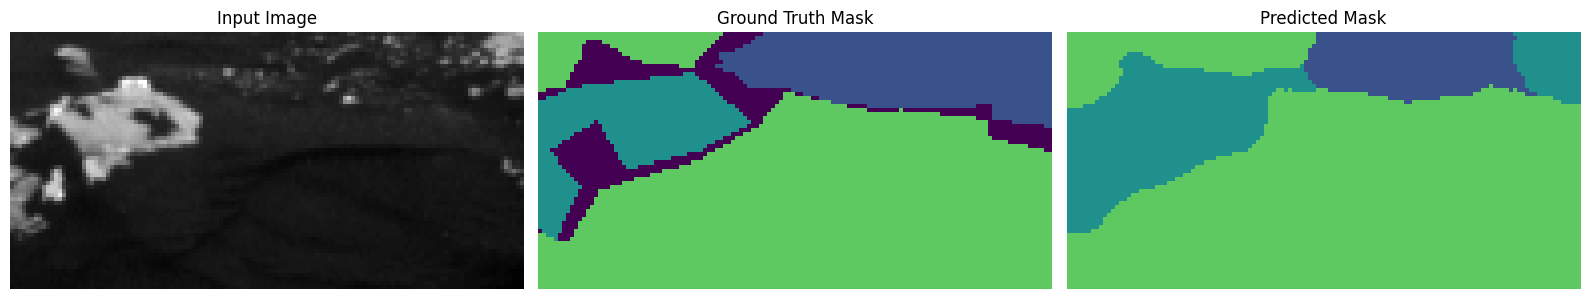

9/9 - 4s - 415ms/step - accuracy: 0.7385 - loss: 2.9760 - mean_iou: 0.7805 - val_accuracy: 0.6751 - val_loss: 3.1110 - val_mean_iou: 0.6464
Epoch 262/1000
9/9 - 3s - 376ms/step - accuracy: 0.7370 - loss: 2.9762 - mean_iou: 0.7448 - val_accuracy: 0.7084 - val_loss: 3.0382 - val_mean_iou: 0.6567
Epoch 263/1000
9/9 - 3s - 376ms/step - accuracy: 0.7401 - loss: 2.9705 - mean_iou: 0.7755 - val_accuracy: 0.7226 - val_loss: 3.0045 - val_mean_iou: 0.7269
Epoch 264/1000
9/9 - 3s - 377ms/step - accuracy: 0.7395 - loss: 2.9729 - mean_iou: 0.7573 - val_accuracy: 0.6901 - val_loss: 3.0965 - val_mean_iou: 0.6556
Epoch 265/1000
9/9 - 3s - 376ms/step - accuracy: 0.7407 - loss: 2.9689 - mean_iou: 0.7642 - val_accuracy: 0.7367 - val_loss: 2.9765 - val_mean_iou: 0.7572
Epoch 266/1000


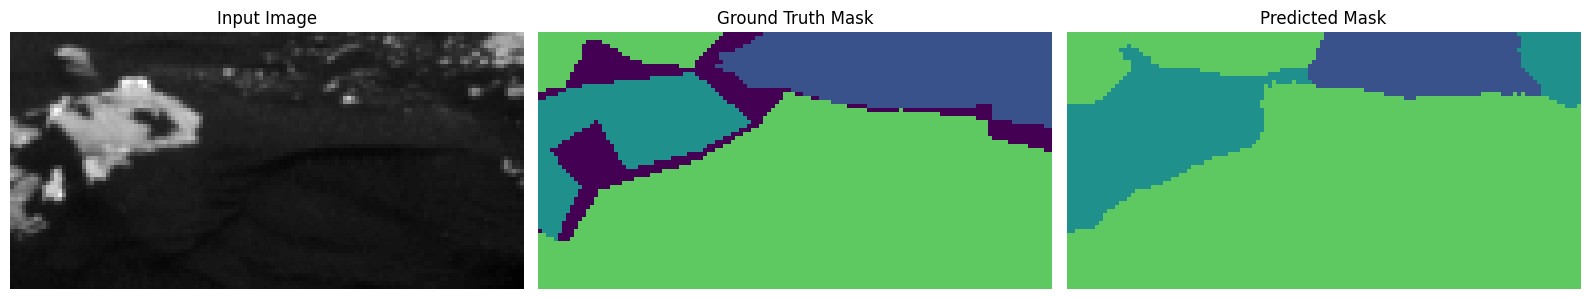

9/9 - 4s - 415ms/step - accuracy: 0.7397 - loss: 2.9706 - mean_iou: 0.7648 - val_accuracy: 0.7281 - val_loss: 2.9944 - val_mean_iou: 0.7487
Epoch 267/1000
9/9 - 3s - 376ms/step - accuracy: 0.7395 - loss: 2.9713 - mean_iou: 0.7701 - val_accuracy: 0.6955 - val_loss: 3.0788 - val_mean_iou: 0.6889
Epoch 268/1000
9/9 - 3s - 376ms/step - accuracy: 0.7304 - loss: 2.9923 - mean_iou: 0.7372 - val_accuracy: 0.5518 - val_loss: 3.4999 - val_mean_iou: 0.4598
Epoch 269/1000
9/9 - 3s - 376ms/step - accuracy: 0.7250 - loss: 2.9991 - mean_iou: 0.7354 - val_accuracy: 0.4964 - val_loss: 3.8276 - val_mean_iou: 0.3877
Epoch 270/1000
9/9 - 3s - 376ms/step - accuracy: 0.7265 - loss: 2.9958 - mean_iou: 0.7281 - val_accuracy: 0.5999 - val_loss: 3.3692 - val_mean_iou: 0.5343
Epoch 271/1000


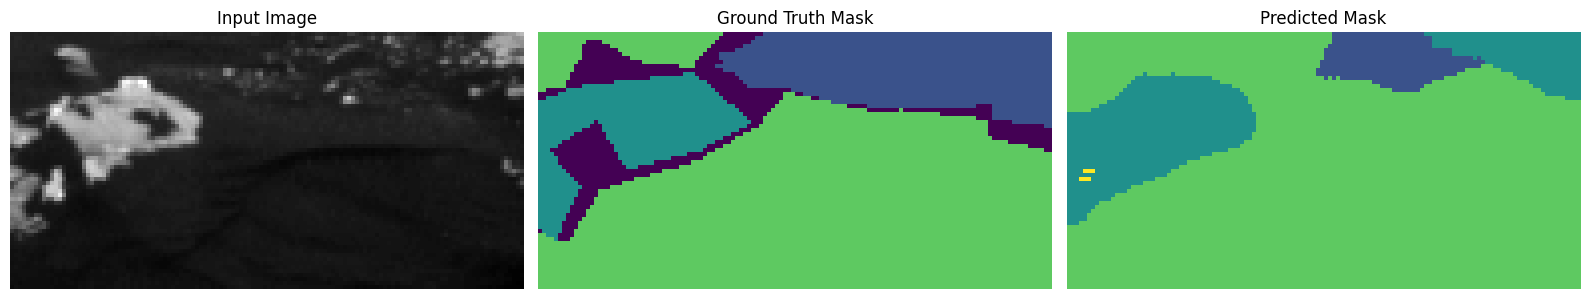

9/9 - 4s - 420ms/step - accuracy: 0.7273 - loss: 2.9973 - mean_iou: 0.7309 - val_accuracy: 0.6833 - val_loss: 3.1129 - val_mean_iou: 0.6293
Epoch 272/1000
9/9 - 3s - 376ms/step - accuracy: 0.7330 - loss: 2.9835 - mean_iou: 0.7413 - val_accuracy: 0.6901 - val_loss: 3.1597 - val_mean_iou: 0.6444
Epoch 273/1000
9/9 - 3s - 377ms/step - accuracy: 0.7334 - loss: 2.9814 - mean_iou: 0.7489 - val_accuracy: 0.7023 - val_loss: 3.0758 - val_mean_iou: 0.6913
Epoch 274/1000
9/9 - 3s - 377ms/step - accuracy: 0.7373 - loss: 2.9769 - mean_iou: 0.7725 - val_accuracy: 0.7284 - val_loss: 3.0052 - val_mean_iou: 0.7175
Epoch 275/1000
9/9 - 3s - 377ms/step - accuracy: 0.7284 - loss: 2.9921 - mean_iou: 0.7528 - val_accuracy: 0.7199 - val_loss: 3.0147 - val_mean_iou: 0.7314
Epoch 276/1000


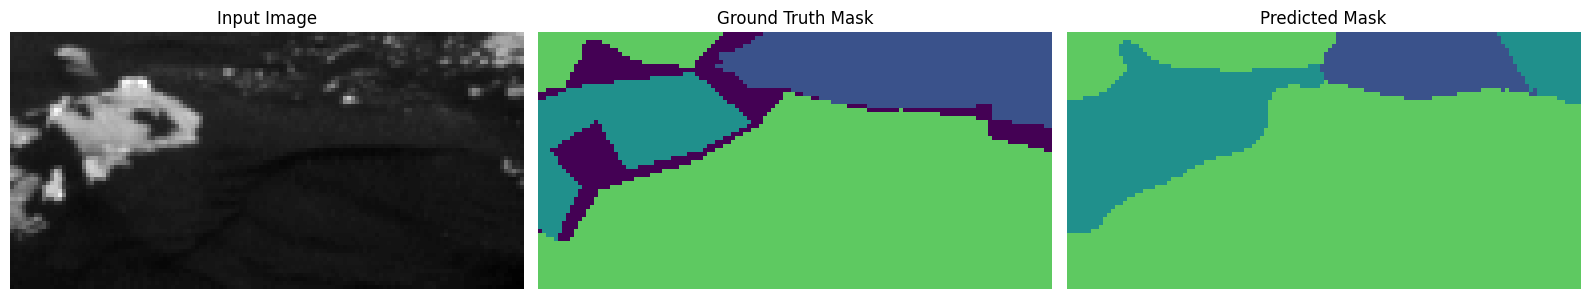

9/9 - 4s - 416ms/step - accuracy: 0.7329 - loss: 2.9830 - mean_iou: 0.7551 - val_accuracy: 0.7013 - val_loss: 3.0924 - val_mean_iou: 0.6865
Epoch 277/1000
9/9 - 3s - 376ms/step - accuracy: 0.7362 - loss: 2.9817 - mean_iou: 0.7458 - val_accuracy: 0.7194 - val_loss: 3.0289 - val_mean_iou: 0.7176
Epoch 278/1000
9/9 - 3s - 377ms/step - accuracy: 0.7391 - loss: 2.9727 - mean_iou: 0.7701 - val_accuracy: 0.6845 - val_loss: 3.1276 - val_mean_iou: 0.6722
Epoch 279/1000
9/9 - 3s - 376ms/step - accuracy: 0.7381 - loss: 2.9758 - mean_iou: 0.7735 - val_accuracy: 0.7140 - val_loss: 3.0276 - val_mean_iou: 0.7180
Epoch 280/1000
9/9 - 3s - 377ms/step - accuracy: 0.7395 - loss: 2.9720 - mean_iou: 0.7790 - val_accuracy: 0.7367 - val_loss: 2.9796 - val_mean_iou: 0.7634
Epoch 281/1000


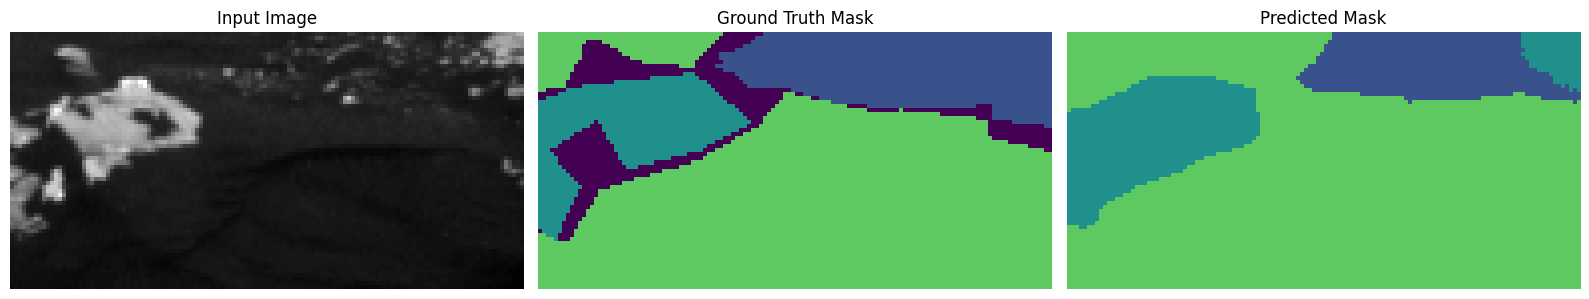

9/9 - 4s - 414ms/step - accuracy: 0.7437 - loss: 2.9652 - mean_iou: 0.7659 - val_accuracy: 0.7398 - val_loss: 2.9701 - val_mean_iou: 0.7887
Epoch 282/1000
9/9 - 3s - 376ms/step - accuracy: 0.7447 - loss: 2.9616 - mean_iou: 0.7992 - val_accuracy: 0.7376 - val_loss: 2.9753 - val_mean_iou: 0.7670
Epoch 283/1000
9/9 - 3s - 381ms/step - accuracy: 0.7456 - loss: 2.9602 - mean_iou: 0.7894 - val_accuracy: 0.7471 - val_loss: 2.9571 - val_mean_iou: 0.7763
Epoch 284/1000
9/9 - 3s - 377ms/step - accuracy: 0.7452 - loss: 2.9612 - mean_iou: 0.7930 - val_accuracy: 0.7416 - val_loss: 2.9678 - val_mean_iou: 0.8029
Epoch 285/1000
9/9 - 3s - 376ms/step - accuracy: 0.7438 - loss: 2.9635 - mean_iou: 0.7985 - val_accuracy: 0.7408 - val_loss: 2.9689 - val_mean_iou: 0.7917
Epoch 286/1000


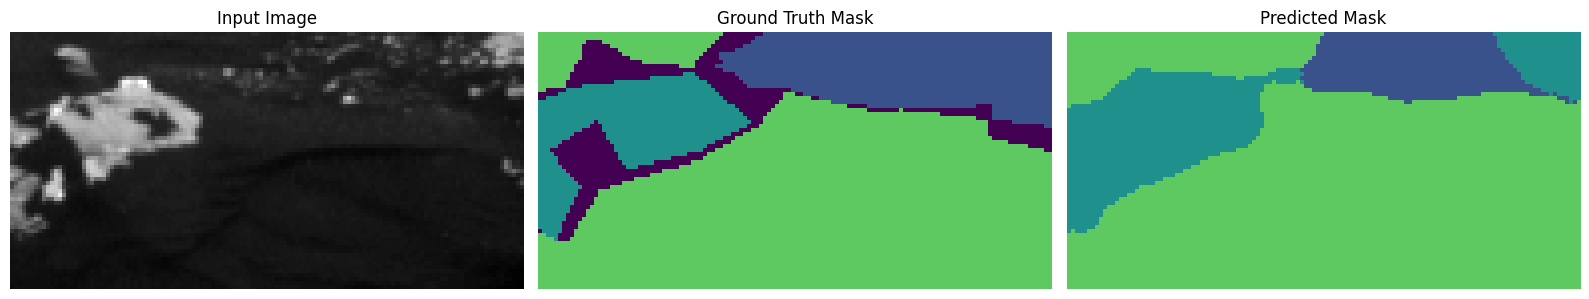

9/9 - 4s - 419ms/step - accuracy: 0.7453 - loss: 2.9608 - mean_iou: 0.8010 - val_accuracy: 0.7241 - val_loss: 2.9976 - val_mean_iou: 0.7310
Epoch 287/1000
9/9 - 3s - 376ms/step - accuracy: 0.7431 - loss: 2.9651 - mean_iou: 0.7851 - val_accuracy: 0.7402 - val_loss: 2.9716 - val_mean_iou: 0.7664
Epoch 288/1000
9/9 - 3s - 376ms/step - accuracy: 0.7433 - loss: 2.9643 - mean_iou: 0.7741 - val_accuracy: 0.7436 - val_loss: 2.9634 - val_mean_iou: 0.7865
Epoch 289/1000
9/9 - 3s - 378ms/step - accuracy: 0.7447 - loss: 2.9623 - mean_iou: 0.7905 - val_accuracy: 0.7462 - val_loss: 2.9589 - val_mean_iou: 0.8096
Epoch 290/1000
9/9 - 3s - 376ms/step - accuracy: 0.7448 - loss: 2.9633 - mean_iou: 0.8042 - val_accuracy: 0.7460 - val_loss: 2.9598 - val_mean_iou: 0.8076
Epoch 291/1000


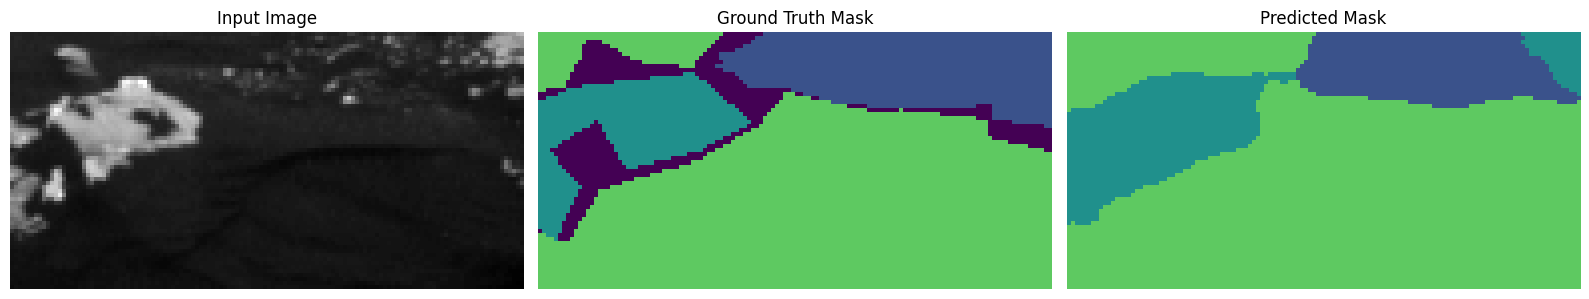

9/9 - 4s - 415ms/step - accuracy: 0.7444 - loss: 2.9630 - mean_iou: 0.8026 - val_accuracy: 0.7412 - val_loss: 2.9683 - val_mean_iou: 0.8005
Epoch 292/1000
9/9 - 3s - 376ms/step - accuracy: 0.7431 - loss: 2.9641 - mean_iou: 0.7854 - val_accuracy: 0.7276 - val_loss: 2.9995 - val_mean_iou: 0.7622
Epoch 293/1000
9/9 - 3s - 376ms/step - accuracy: 0.7408 - loss: 2.9689 - mean_iou: 0.7824 - val_accuracy: 0.7432 - val_loss: 2.9647 - val_mean_iou: 0.7829
Epoch 294/1000
9/9 - 3s - 376ms/step - accuracy: 0.7392 - loss: 2.9718 - mean_iou: 0.7832 - val_accuracy: 0.6491 - val_loss: 3.3058 - val_mean_iou: 0.6491
Epoch 295/1000
9/9 - 3s - 377ms/step - accuracy: 0.7431 - loss: 2.9663 - mean_iou: 0.7808 - val_accuracy: 0.7421 - val_loss: 2.9655 - val_mean_iou: 0.7825
Epoch 296/1000


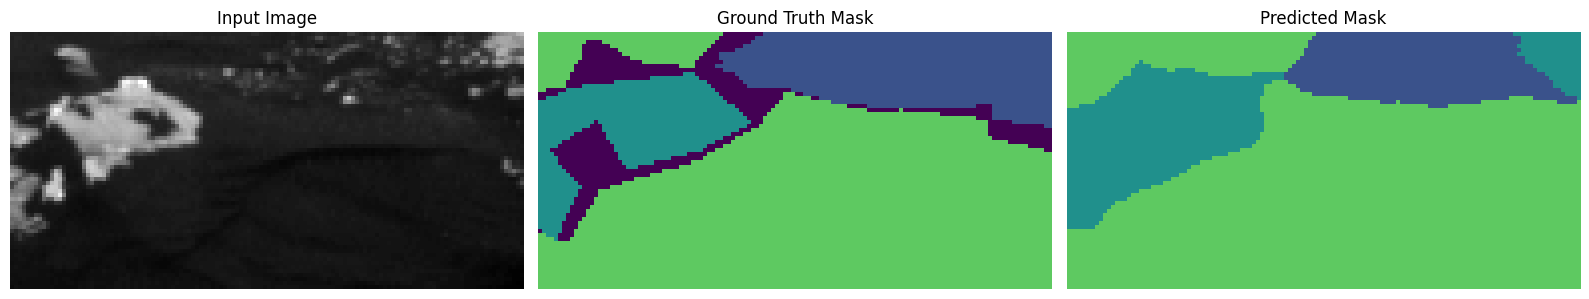

9/9 - 4s - 416ms/step - accuracy: 0.7450 - loss: 2.9608 - mean_iou: 0.8098 - val_accuracy: 0.7423 - val_loss: 2.9662 - val_mean_iou: 0.8004
Epoch 297/1000
9/9 - 3s - 376ms/step - accuracy: 0.7465 - loss: 2.9582 - mean_iou: 0.8068 - val_accuracy: 0.7442 - val_loss: 2.9626 - val_mean_iou: 0.8151
Epoch 298/1000
9/9 - 3s - 378ms/step - accuracy: 0.7463 - loss: 2.9586 - mean_iou: 0.8015 - val_accuracy: 0.7429 - val_loss: 2.9646 - val_mean_iou: 0.7951
Epoch 299/1000
9/9 - 3s - 378ms/step - accuracy: 0.7456 - loss: 2.9593 - mean_iou: 0.8192 - val_accuracy: 0.7442 - val_loss: 2.9635 - val_mean_iou: 0.8075
Epoch 300/1000
9/9 - 3s - 377ms/step - accuracy: 0.7454 - loss: 2.9608 - mean_iou: 0.8129 - val_accuracy: 0.7445 - val_loss: 2.9620 - val_mean_iou: 0.8079
Epoch 301/1000


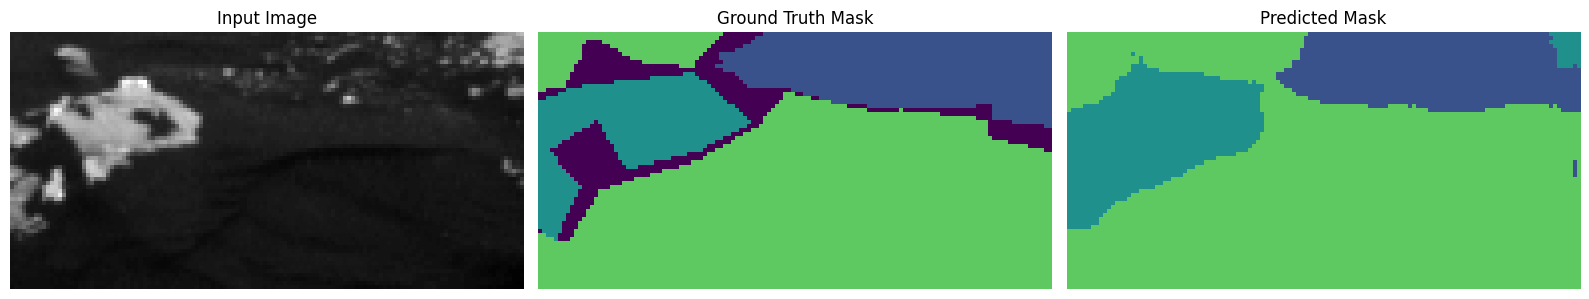

9/9 - 4s - 414ms/step - accuracy: 0.7474 - loss: 2.9565 - mean_iou: 0.8310 - val_accuracy: 0.7486 - val_loss: 2.9555 - val_mean_iou: 0.8286
Epoch 302/1000
9/9 - 3s - 377ms/step - accuracy: 0.7471 - loss: 2.9566 - mean_iou: 0.8220 - val_accuracy: 0.7482 - val_loss: 2.9549 - val_mean_iou: 0.8488
Epoch 303/1000
9/9 - 3s - 377ms/step - accuracy: 0.7449 - loss: 2.9604 - mean_iou: 0.8017 - val_accuracy: 0.7465 - val_loss: 2.9583 - val_mean_iou: 0.8287
Epoch 304/1000
9/9 - 3s - 376ms/step - accuracy: 0.7465 - loss: 2.9580 - mean_iou: 0.8324 - val_accuracy: 0.7473 - val_loss: 2.9572 - val_mean_iou: 0.8327
Epoch 305/1000
9/9 - 3s - 382ms/step - accuracy: 0.7475 - loss: 2.9565 - mean_iou: 0.8252 - val_accuracy: 0.7488 - val_loss: 2.9537 - val_mean_iou: 0.8434
Epoch 306/1000


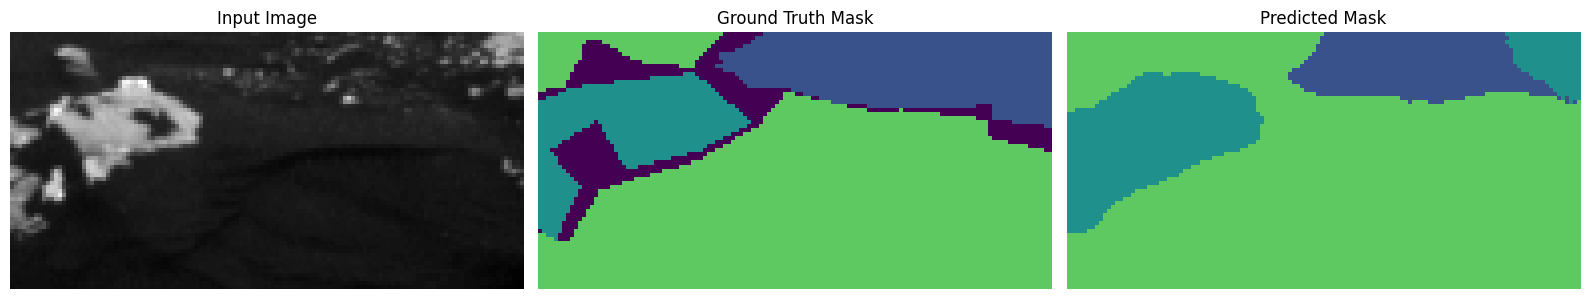

9/9 - 4s - 407ms/step - accuracy: 0.7484 - loss: 2.9546 - mean_iou: 0.8274 - val_accuracy: 0.7463 - val_loss: 2.9589 - val_mean_iou: 0.8172
Epoch 307/1000
9/9 - 3s - 377ms/step - accuracy: 0.7485 - loss: 2.9541 - mean_iou: 0.8273 - val_accuracy: 0.7485 - val_loss: 2.9546 - val_mean_iou: 0.8267
Epoch 308/1000
9/9 - 3s - 382ms/step - accuracy: 0.7470 - loss: 2.9566 - mean_iou: 0.8295 - val_accuracy: 0.7507 - val_loss: 2.9498 - val_mean_iou: 0.8557
Epoch 309/1000
9/9 - 3s - 383ms/step - accuracy: 0.7472 - loss: 2.9565 - mean_iou: 0.8288 - val_accuracy: 0.7509 - val_loss: 2.9497 - val_mean_iou: 0.8623
Epoch 310/1000
9/9 - 3s - 376ms/step - accuracy: 0.7444 - loss: 2.9623 - mean_iou: 0.8322 - val_accuracy: 0.7440 - val_loss: 2.9624 - val_mean_iou: 0.8279
Epoch 311/1000


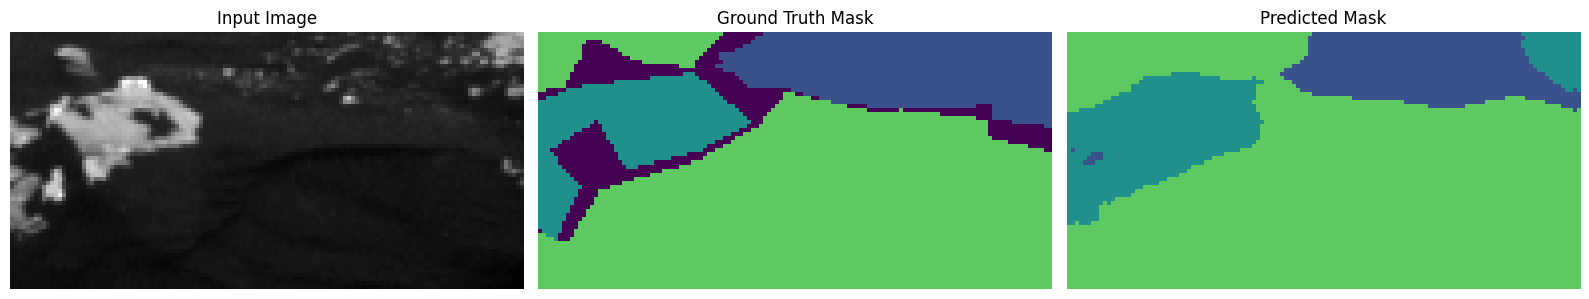

9/9 - 4s - 415ms/step - accuracy: 0.7464 - loss: 2.9585 - mean_iou: 0.8267 - val_accuracy: 0.7483 - val_loss: 2.9556 - val_mean_iou: 0.8274
Epoch 312/1000
9/9 - 3s - 376ms/step - accuracy: 0.7472 - loss: 2.9574 - mean_iou: 0.8124 - val_accuracy: 0.7469 - val_loss: 2.9563 - val_mean_iou: 0.8433
Epoch 313/1000
9/9 - 3s - 376ms/step - accuracy: 0.7490 - loss: 2.9529 - mean_iou: 0.8385 - val_accuracy: 0.7484 - val_loss: 2.9544 - val_mean_iou: 0.8482
Epoch 314/1000
9/9 - 3s - 376ms/step - accuracy: 0.7490 - loss: 2.9530 - mean_iou: 0.8346 - val_accuracy: 0.7481 - val_loss: 2.9537 - val_mean_iou: 0.8622
Epoch 315/1000
9/9 - 3s - 377ms/step - accuracy: 0.7491 - loss: 2.9527 - mean_iou: 0.8424 - val_accuracy: 0.7499 - val_loss: 2.9519 - val_mean_iou: 0.8729
Epoch 316/1000


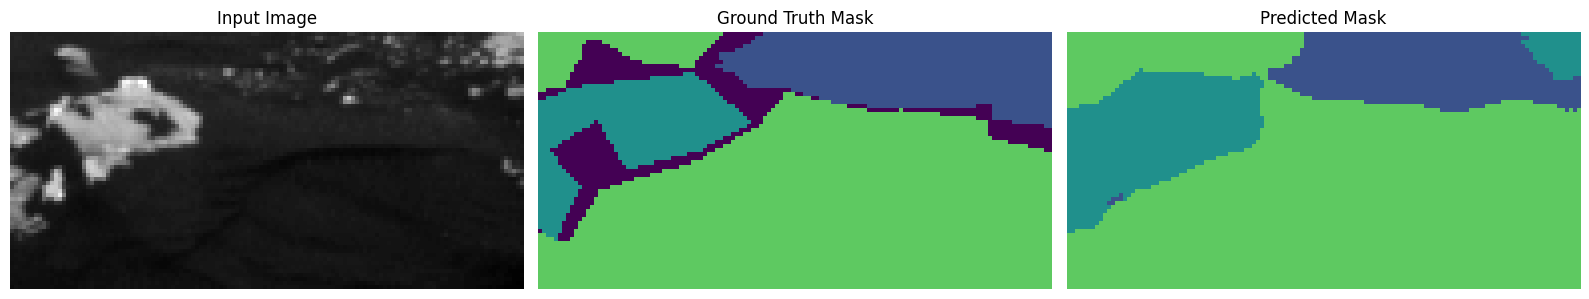

9/9 - 4s - 417ms/step - accuracy: 0.7480 - loss: 2.9552 - mean_iou: 0.8460 - val_accuracy: 0.7507 - val_loss: 2.9501 - val_mean_iou: 0.8602
Epoch 317/1000
9/9 - 3s - 379ms/step - accuracy: 0.7457 - loss: 2.9595 - mean_iou: 0.8313 - val_accuracy: 0.7457 - val_loss: 2.9594 - val_mean_iou: 0.8383
Epoch 318/1000
9/9 - 3s - 376ms/step - accuracy: 0.7475 - loss: 2.9561 - mean_iou: 0.8272 - val_accuracy: 0.7309 - val_loss: 2.9951 - val_mean_iou: 0.8054
Epoch 319/1000
9/9 - 3s - 376ms/step - accuracy: 0.7464 - loss: 2.9584 - mean_iou: 0.8432 - val_accuracy: 0.7269 - val_loss: 3.0035 - val_mean_iou: 0.8012
Epoch 320/1000
9/9 - 3s - 377ms/step - accuracy: 0.7459 - loss: 2.9592 - mean_iou: 0.8420 - val_accuracy: 0.7260 - val_loss: 3.0009 - val_mean_iou: 0.8073
Epoch 321/1000


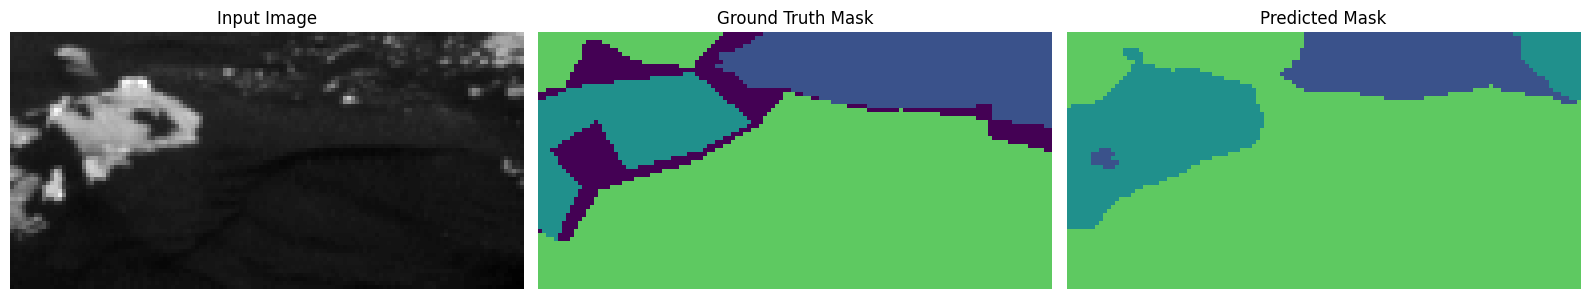

9/9 - 4s - 475ms/step - accuracy: 0.7460 - loss: 2.9594 - mean_iou: 0.8350 - val_accuracy: 0.7446 - val_loss: 2.9595 - val_mean_iou: 0.8502
Epoch 322/1000
9/9 - 3s - 377ms/step - accuracy: 0.7451 - loss: 2.9604 - mean_iou: 0.8183 - val_accuracy: 0.6945 - val_loss: 3.0886 - val_mean_iou: 0.7155
Epoch 323/1000
9/9 - 3s - 377ms/step - accuracy: 0.7454 - loss: 2.9601 - mean_iou: 0.8214 - val_accuracy: 0.6931 - val_loss: 3.0967 - val_mean_iou: 0.6827
Epoch 324/1000
9/9 - 3s - 377ms/step - accuracy: 0.7403 - loss: 2.9710 - mean_iou: 0.7936 - val_accuracy: 0.7217 - val_loss: 3.0139 - val_mean_iou: 0.7225
Epoch 325/1000
9/9 - 3s - 378ms/step - accuracy: 0.7431 - loss: 2.9633 - mean_iou: 0.8199 - val_accuracy: 0.7290 - val_loss: 2.9967 - val_mean_iou: 0.7594
Epoch 326/1000


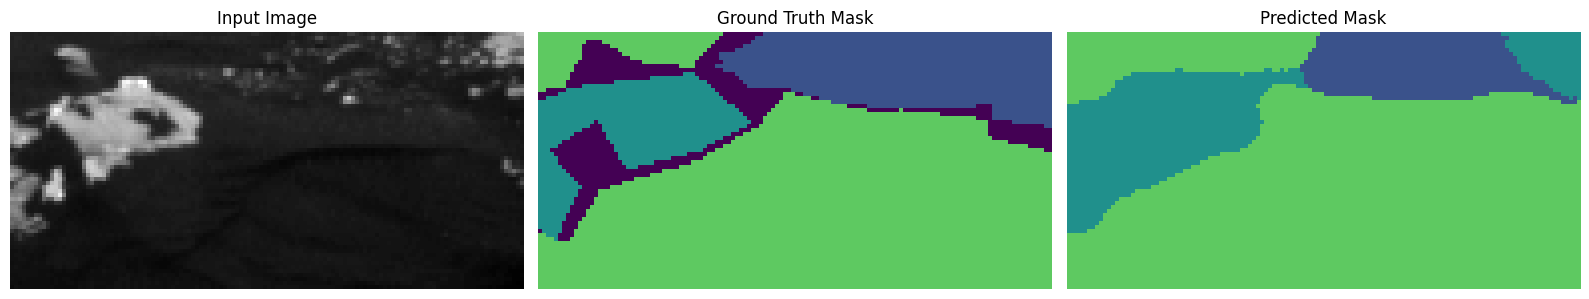

9/9 - 4s - 408ms/step - accuracy: 0.7434 - loss: 2.9654 - mean_iou: 0.8147 - val_accuracy: 0.7452 - val_loss: 2.9627 - val_mean_iou: 0.8428
Epoch 327/1000
9/9 - 3s - 377ms/step - accuracy: 0.7426 - loss: 2.9641 - mean_iou: 0.8186 - val_accuracy: 0.7229 - val_loss: 3.0125 - val_mean_iou: 0.7254
Epoch 328/1000
9/9 - 3s - 377ms/step - accuracy: 0.7387 - loss: 2.9759 - mean_iou: 0.7842 - val_accuracy: 0.7361 - val_loss: 2.9826 - val_mean_iou: 0.7732
Epoch 329/1000
9/9 - 3s - 377ms/step - accuracy: 0.7407 - loss: 2.9698 - mean_iou: 0.8145 - val_accuracy: 0.7338 - val_loss: 2.9860 - val_mean_iou: 0.7950
Epoch 330/1000
9/9 - 3s - 377ms/step - accuracy: 0.7419 - loss: 2.9657 - mean_iou: 0.8266 - val_accuracy: 0.7435 - val_loss: 2.9632 - val_mean_iou: 0.8415
Epoch 331/1000


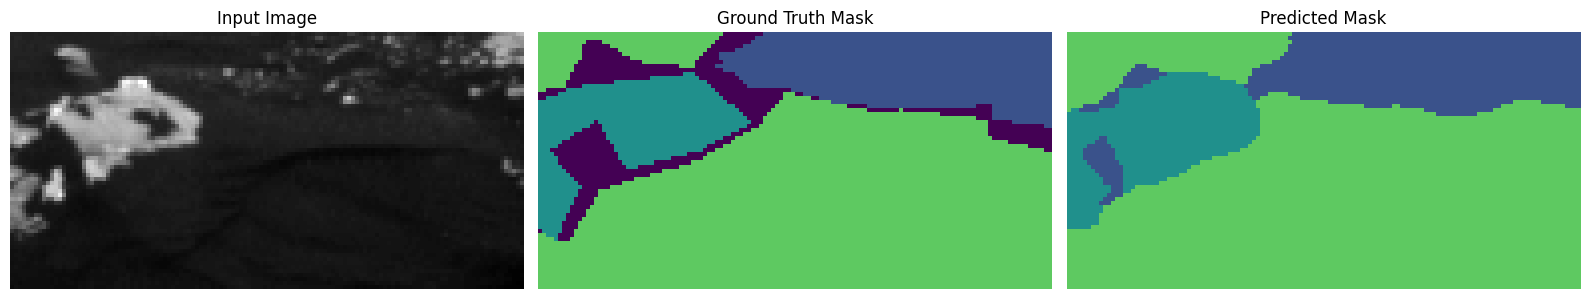

9/9 - 4s - 406ms/step - accuracy: 0.7440 - loss: 2.9616 - mean_iou: 0.8170 - val_accuracy: 0.7432 - val_loss: 2.9644 - val_mean_iou: 0.8355
Epoch 332/1000
9/9 - 3s - 377ms/step - accuracy: 0.7445 - loss: 2.9615 - mean_iou: 0.8122 - val_accuracy: 0.7446 - val_loss: 2.9608 - val_mean_iou: 0.8366
Epoch 333/1000
9/9 - 3s - 377ms/step - accuracy: 0.7446 - loss: 2.9610 - mean_iou: 0.8213 - val_accuracy: 0.7392 - val_loss: 2.9772 - val_mean_iou: 0.8214
Epoch 334/1000
9/9 - 3s - 377ms/step - accuracy: 0.7446 - loss: 2.9600 - mean_iou: 0.8291 - val_accuracy: 0.6114 - val_loss: 3.4342 - val_mean_iou: 0.5760
Epoch 335/1000
9/9 - 3s - 377ms/step - accuracy: 0.7458 - loss: 2.9586 - mean_iou: 0.8200 - val_accuracy: 0.6553 - val_loss: 3.2424 - val_mean_iou: 0.6320
Epoch 336/1000


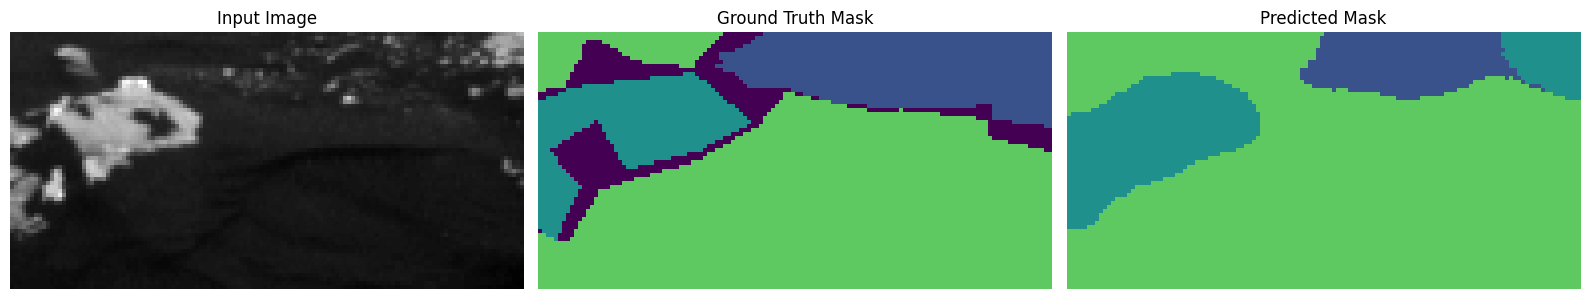

9/9 - 4s - 416ms/step - accuracy: 0.7457 - loss: 2.9586 - mean_iou: 0.8258 - val_accuracy: 0.7432 - val_loss: 2.9621 - val_mean_iou: 0.8354
Epoch 337/1000
9/9 - 3s - 377ms/step - accuracy: 0.7480 - loss: 2.9545 - mean_iou: 0.8391 - val_accuracy: 0.7464 - val_loss: 2.9578 - val_mean_iou: 0.8468
Epoch 338/1000
9/9 - 3s - 378ms/step - accuracy: 0.7474 - loss: 2.9564 - mean_iou: 0.8222 - val_accuracy: 0.7470 - val_loss: 2.9572 - val_mean_iou: 0.8500
Epoch 339/1000
9/9 - 3s - 377ms/step - accuracy: 0.7484 - loss: 2.9547 - mean_iou: 0.8595 - val_accuracy: 0.7066 - val_loss: 3.0358 - val_mean_iou: 0.7736
Final validation Mean Intersection Over Union: 87.29%
UNet_87.29.keras


In [52]:
# Train the model

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=2
).history



# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model
print(model_filename)

In [53]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Predictions shape: (10022, 64, 128)
